# Introduction to Dynamic Circuits and QEC with Qiskit

**Qiskit Slack: @Quantom & @Micheal Healy & Ed Chen**

**Github: taalexander & @mbhealy & @ehchen**

Before running this tutorial make sure you are setup with the [Hello IEEE notebook](./hello-ieee.ipynb).

- This tutorial introduces the current dynamic circuit support through Qiskit on IBM Quantum hardware. This will change quickly as we develop this functionality, and we will aim to keep this tutorial up-to-date with the latest features and functionality. 
- We will then run some very simple error-correction in the form of a bit-flip code
- At the end we will complete some exercises, the solutions may be found in the [solution notebook](./ieee-qec-tutorial-2022-solutions.ipynb).

In [196]:
import os
from typing import Any, Dict, List, Optional, Union

import numpy as np
import matplotlib.pyplot as plt

from qiskit import IBMQ, QuantumCircuit, QuantumRegister, ClassicalRegister, quantum_info as qi
from qiskit.providers.ibmq import RunnerResult
from qiskit.result import marginal_counts
import qiskit.tools.jupyter

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


In [197]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Running Dynamic Circuits with Qiskit

Fist we need to instantiate our Qiskit runtime service instance and load our backend.

In [198]:
# Note: This can be any hub/group/project that has access to the required device and the Qiskit runtime.
# Verify that ``qasm3`` is present in ``backend.configuration().supported_features``.
hub = "ibm-q-community"
group = "ieee-demos"
project = "main"
backend_name = "ibm_peekskill"

In [199]:
# Remove before going public
hub = "ibm-q-internal"
group = "dev-sys-software"
project = "internal-test"
backend_name = "ibm_peekskill"

In [200]:
from qiskit.circuit import Delay, Parameter
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.backend(backend_name, instance=f"{hub}/{group}/{project}")

In [201]:
# Address bug in the current Qiskit runtime package
target = backend.target
if "delay" not in target:
    target.add_instruction(
        Delay(Parameter("t")), {(bit,): None for bit in range(target.num_qubits)}
    )

As we will also enable simulation for most of our experiments to prevent congestion in the reserved hardware we load some simulation backends.

In [202]:
from qiskit.providers.aer import AerSimulator, Aer
from qiskit.providers.aer.noise import NoiseModel

backend_noise_model = NoiseModel.from_backend(backend)
backend_sim = AerSimulator(noise_model=backend_noise_model)
ideal_sim = Aer.get_backend('qasm_simulator')

In [203]:
import utils
backend

<IBMBackend('ibm_peekskill')>

In [204]:
### Running the bit flip code in hardware

shots = 1024

init_num_resets = 3 # Set the number of resets to initialize qubits between circuits
init_delay = 0. # Set the initialization idle time for qubits

sim = True # Set True to simulate our experiments and False to run in hardware
dynamical_decoupling = False # Set True to enable dynamical decoupling

In [205]:
import mapomatic as mm
from qiskit.circuit.library import XGate
from qiskit.transpiler import PassManager
from qiskit.transpiler.instruction_durations import InstructionDurations
from qiskit_ibm_runtime import RuntimeJob, IBMBackend

def convert_cycles(time_in_seconds: float, backend: IBMBackend) -> int:
    cycles = time_in_seconds / (backend.configuration().dt)
    return int(cycles + (16 - (cycles % 16)))

def execute(circuits: List[QuantumCircuit], verbose: bool = True, **kwargs) -> RuntimeJob:
    """A helper method to execute circuits with common settings in the notebook.
    
    Args:
        circuits: To execute.
        verbose: Emit execution information.
        sim: Run with simulator instead of hardware. By default reads global variable "sim"
    
    """
    if isinstance(circuits, QuantumCircuit):
        circuits = [circuits]

    if sim:
        return backend_sim.run(circuits, shots=shots, **kwargs)
    else:
        import mapomatic as mm
        deflated_circuits = []
        for circuit in circuits:
            # Required because of https://github.ibm.com/IBM-Q-Software/vt-dynamic-circuits/issues/1106
            deflated_circuit = mm.deflate_circuit(circuit)
            deflated_circuit.name = circuit.name
            deflated_circuits.append(deflated_circuit)
    
        job = run_openqasm3(circuits, backend, verbose=False, shots=shots, init_num_resets=init_num_resets, init_delay=init_delay, **kwargs)
        if verbose:
            print(f"Running on qasm3, job id: {job.job_id}")

        return job
    
def calculate_initial_layout(
    circuit: QuantumCircuit, 
    mapomatic: Optional[bool] = None, 
    favourite_qubits: Optional[List[int]] = None, 
    blacklist_qubits: Optional[List[int]] = None
) -> List[int]:
    """Routine to help choose the ideal qubit layout given an input circuit.
    
    Args:
        circuit: To evaluate layout for.
        mapomatic: Use mapomatic to choose ideal qubits, otherwise naievly choose ``favourite_qubits``
        favourite_qubits: A list of favourite qubits to ensure are in the layout
        blacklist_qubits: Qubits that are not allowed in the layout.
    """
    deflated = mm.deflate_circuit(circuit)
    if mapomatic:
        deflated = mm.deflate_circuit(circuit)
        available_layouts = [layout for layout in mm.matching_layouts(deflated, backend.configuration().coupling_map, strict_direction=False) if layout[:len(favourite_qubits)] == favourite_qubits and not set(layout).intersection(set(blacklist_qubits))]
        scores = mm.evaluate_layouts(deflated, available_layouts, backend)
        return scores[0][0]
    
    if favourite_qubits is None:
        favourite_qubits = []
    
    if blacklist_qubits is None:
        blacklist_qubits = []
        
    return (favourite_qubits + list(set(range(backend.num_qubits)) - set(favourite_qubits)))[:deflated.num_qubits]

def apply_dynamical_decoupling(
    circuits: List[QuantumCircuit], 
    backend: IBMBackend, 
    initial_layout: List[int],
) -> List[QuantumCircuit]:
    """Apply dynamic circuit dynamical decoupling."""

    from qiskit_ibm_provider.transpiler.passes.scheduling import DynamicCircuitScheduleAnalysis, PadDynamicalDecoupling
    dd_sequence = [XGate(), XGate()]
    durations = InstructionDurations.from_backend(backend)
    pm = PassManager(
        [
            DynamicCircuitScheduleAnalysis(durations),
            PadDynamicalDecoupling(durations, dd_sequence, qubits=initial_layout),
        ]
    )
    return pm.run(circuits)

def apply_transpile(
    circuits: List[QuantumCircuit], 
    backend: IBMBackend, 
    initial_layout: List[int], 
    dynamical_decoupling: bool = dynamical_decoupling, 
    **transpile_kwargs,
) -> List[QuantumCircuit]:
    """Fixed transpile routine to be used for consistency throughout the notebook."""

    transpiled_circuits = transpile(circuits, backend, initial_layout=initial_layout, optimization_level=3, **transpile_kwargs)
    if dynamical_decoupling:
        return apply_dynamical_decoupling(transpiled_circuits, backend, initial_layout)
    return transpiled_circuits

# Running Dynamic Circuits

We want to provide more expressive semantics in our users, so they can explore quantum error correction and other applications requiring real-time compute.

In [206]:
qubit = 0

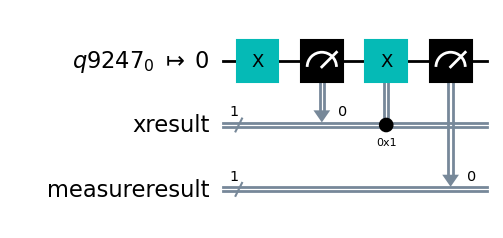

In [207]:
from utils import run_openqasm3

from qiskit import QuantumRegister, ClassicalRegister, transpile

qr = QuantumRegister(1)
crx = ClassicalRegister(1, name="xresult")
crm = ClassicalRegister(1, name="measureresult")
qc_reset = QuantumCircuit(qr, crx, crm, name="Reset")
qc_reset.x(0)
qc_reset.measure(0, crx)
qc_reset.x(0).c_if(crx, 1)
qc_reset.measure(0, crm)

qc_reset = transpile(qc_reset, backend)
qc_reset.draw(output="mpl", idle_wires=False)

Now, let's interpret the results

In [208]:
reset_job = run_openqasm3(qc_reset, backend, verbose=True, shots=shots, init_num_resets=0, init_delay=0) # Turn off automatic init

=======Reset=======
=======QASM3======
OPENQASM 3;
bit[1] xresult;
bit[1] measureresult;
x $0;
xresult[0] = measure $0;
if (xresult == 1) {
  x $0;
}
measureresult[0] = measure $0;

                 ┌───┐┌─┐ ┌───┐ ┌─┐
    q9247_0 -> 0 ┤ X ├┤M├─┤ X ├─┤M├
                 └───┘└╥┘ └─╥─┘ └╥┘
                       ║ ┌──╨──┐ ║ 
      xresult: 1/══════╩═╡ 0x1 ╞═╬═
                       0 └─────┘ ║ 
measureresult: 1/════════════════╩═
                                 0 
Running: cci7vbae26g1vq2s1hrg
=======Reset=======
{'0 0': 32, '0 1': 978, '1 0': 1, '1 1': 13}


In [209]:

from qiskit.result import marginal_counts

reset_result = reset_job.result()
reset_counts = reset_result.get_counts(0)
mitigated_reset_results = marginal_counts(reset_counts, indices=[1])
print(f"Full counts including reset: {reset_counts}")
print(f"Results from our reset - |0>s prepared {mitigated_reset_results.get('0')}, |1>s prepared {mitigated_reset_results.get('1', 0)}"
)

Full counts including reset: {'0 0': 32, '0 1': 978, '1 0': 1, '1 1': 13}
Results from our reset - |0>s prepared 1010, |1>s prepared 14


#### What is going on in the backgroud?

**Note**: In a future release of the `qiskit-ibm-provider`, we will release an updated interface in the form of `backend.run(circuit)` which invokes the Qiskit Runtime.

We are submitting circuit jobs to a [Qiskit Runtime](https://quantum-computing.ibm.com/lab/docs/iql/runtime/) program that exposes a ``backend.run(circuits, ...)`` like interface, but which accepts either ``QuantumCircuit`` or OpenQASM 3 strings for ``circuits``.

![Qiskit Runtime](https://iqx-docs.quantum-computing.ibm.com/_images/Qiskit_Runtime_architecture1.png)

### Submit an OpenQASM 3 string directly

This is useful for the cases where the `QuantumCircuit` does not yet support all of the semantics of OpenQASM 3. To see what features of OpenQASM 3 are currently supported in hardware, please see the [feature support table here](https://quantum-computing.ibm.com/services/docs/services/manage/systems/dynamic-circuits/feature-table).

We can get the OpenQASM 3 for our circuit from Qiskit.

**Note**: We current do not merge your circuits into a single execution when OpenQASM 3 source strings are submitted directly. In this case each OpenQASM 3 source will be run as an individual execution and will take significantly longer to execute in the hardware.

In [210]:
from qiskit import qasm3

basis_gates = backend.configuration().basis_gates

def dump_qasm3(circuit: QuantumCircuit, backend: IBMBackend = backend) -> str:
    return qasm3.Exporter(includes=[],
                          basis_gates=backend.configuration().basis_gates,
                          disable_constants=True).dumps(circuit)

qasm3_reset = dump_qasm3(qc_reset)
print(qasm3_reset)

OPENQASM 3;
bit[1] xresult;
bit[1] measureresult;
x $0;
xresult[0] = measure $0;
if (xresult == 1) {
  x $0;
}
measureresult[0] = measure $0;



For the rest of the tutorial we will use the method `run_openqasm3` which is a simple wrapper around the runtime calls above with some additional logging.

In [211]:
runtime_job = run_openqasm3(qasm3_reset, backend, verbose=True, shots=shots, init_num_resets=0, init_delay=0)

=======QASM3======
OPENQASM 3;
bit[1] xresult;
bit[1] measureresult;
x $0;
xresult[0] = measure $0;
if (xresult == 1) {
  x $0;
}
measureresult[0] = measure $0;

Running: cci7vhvju75bgnkcrnu0
{'0': 22, '1': 928, '10': 2, '11': 72}


### OpenQASM 3 gives us more classical compute
The semantics of OpenQASM 3 enable more classical compute than is currently
available in Qiskit. For now we can access this by submitting OpenQASM 3 directly.

In [212]:
classical_compute_qasm3 = """
OPENQASM 3.0;

bit a;
bit b;
bit c;

x $0;
x $2;

a = measure $0; // expected "1"
b = measure $1; // expected "0"
c = measure $2; // expected "0"

bit[3] d = "100";


if (((a | b) & c) == 1) {
    // Path will nearly always execute
    d[0] = 1;
} else {
    // Path will rarely execute outside of SPAM errors
    d[0] = 0;
}

bit [3] e = "101";
// Conditionally execute based on classical bit array comparison
// Should always execute
if (d == e) {
    x $1;
}

bit final;
final = measure $1; // expected 0
"""

classical_compute_job = run_openqasm3(classical_compute_qasm3, backend, verbose=True, shots=shots)

=======QASM3======

OPENQASM 3.0;

bit a;
bit b;
bit c;

x $0;
x $2;

a = measure $0; // expected "1"
b = measure $1; // expected "0"
c = measure $2; // expected "0"

bit[3] d = "100";


if (((a | b) & c) == 1) {
    // Path will nearly always execute
    d[0] = 1;
} else {
    // Path will rarely execute outside of SPAM errors
    d[0] = 0;
}

bit [3] e = "101";
// Conditionally execute based on classical bit array comparison
// Should always execute
if (d == e) {
    x $1;
}

bit final;
final = measure $1; // expected 0

Running: cci7vnvju75bgnkcro3g
{'0': 7, '1': 83, '1000000011': 9, '1000000100': 2, '1000000101': 802, '1000000110': 1, '1000000111': 2, '100': 49, '101': 11, '110': 5, '111': 53}


### Using compute capabilities

## Teleport a Quantum State

Visit the Qiskit Textbook to know more about [Quantum teleportation](https://qiskit.org/textbook/ch-algorithms/teleportation.html).

<img src="figs/telamon.jpeg" alt="drawing" style="width:700px;"/>

**Step 1: Prepare the teleportation circuit**

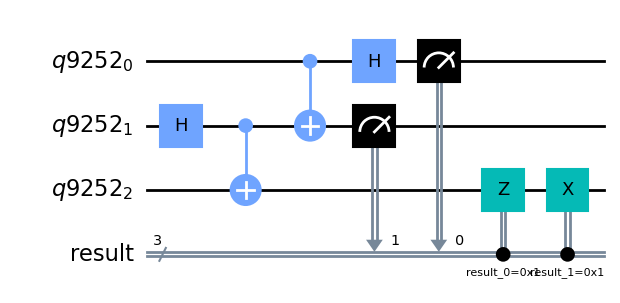

In [213]:
qr = QuantumRegister(3)
cr = ClassicalRegister(3, name="result")
crz = cr[0]
crx = cr[1]
result = cr[2]

qc_teleport = QuantumCircuit(qr, cr, name="Teleport")

# Apply teleportation circuit
qc_teleport.h(qr[1])
qc_teleport.cx(qr[1], qr[2])
qc_teleport.cx(qr[0], qr[1])
qc_teleport.h(qr[0])
qc_teleport.measure(qr[0], crz)
qc_teleport.measure(qr[1], crx)
qc_teleport.z(qr[2]).c_if(crz, 1)
qc_teleport.x(qr[2]).c_if(crx, 1)
qc_teleport.draw(output="mpl")

**Step 2: Prepare the Teleport experiment Circuit**

In [214]:
# Prepare |1> for teleportation
qc_state_prep = QuantumCircuit(1)
qc_state_prep.x(0)
print(qc_state_prep)

target_state_prep = qi.Statevector.from_instruction(qc_state_prep)
print(target_state_prep)

   ┌───┐
q: ┤ X ├
   └───┘
Statevector([0.+0.j, 1.+0.j],
            dims=(2,))


**Step 3: Compose the state initialization with the teleportation**

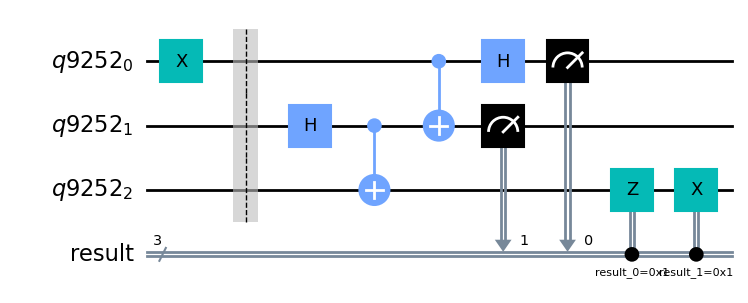

In [215]:
teleport_qubits = [2, 3, 5]

qc_teleport_state = QuantumCircuit(qr, cr, name="Teleport Hadamard")

# Prepare state to teleport
qc_teleport_state.compose(qc_state_prep, [qr[0]], inplace=True)
qc_teleport_state.barrier(qr)

# Compose with teleportation circuit
qc_teleport_state.compose(qc_teleport, inplace=True)

qc_teleport_state.draw(output="mpl")

**Step 4: Transpile for backend and execute**

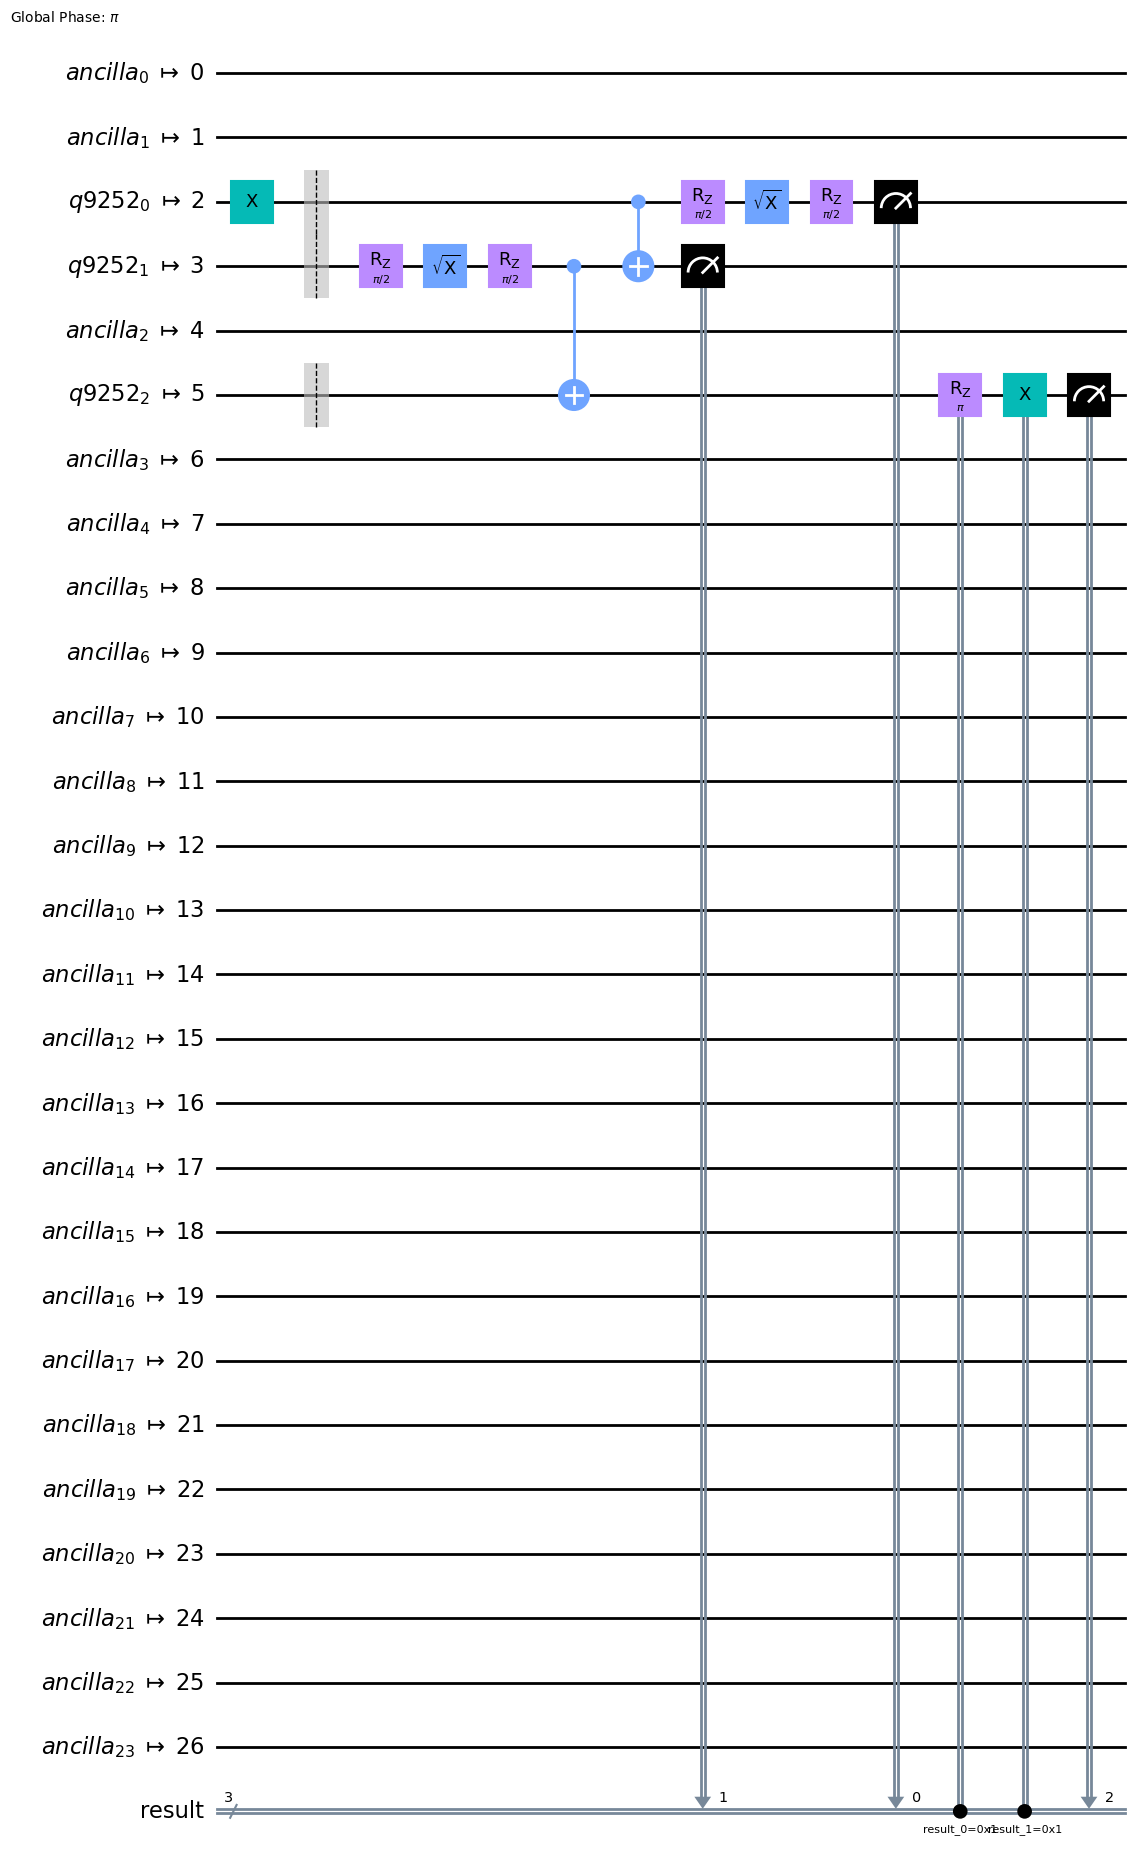

In [216]:
qc_teleport_experiment = qc_teleport_state.copy()
qc_teleport_experiment.measure(qr[2], result)
qc_teleport_experiment = apply_transpile(qc_teleport_experiment, backend, initial_layout=teleport_qubits)
qc_teleport_experiment.draw(output="mpl", idle_wires=True)

In [217]:
teleport_job = execute(qc_teleport_experiment)

In [218]:
teleport_result = teleport_job.result()
print(f"All teleportation counts: {teleport_result.get_counts(0)}")

marginal_teleport_counts = marginal_counts(teleport_result.get_counts(0), indices=[2])
print(f"Marginalized teleportation counts: {marginal_teleport_counts}")

All teleportation counts: {'100': 5, '001': 11, '010': 8, '000': 1000}
Marginalized teleportation counts: {'1': 5, '0': 1019}


## Running basic quantum error correction

*Note*: This tutorial draws heavily from these excellent tutorials [1](https://qiskit.org/textbook/ch-quantum-hardware/error-correction-repetition-code.html) [2](https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/awards/teach_me_quantum_2018/intro2qc/10.Quantum%20error%20correction.ipynb).

A few more excellent references for an introduction to quantum error correction [3](https://www2.physics.ox.ac.uk/sites/default/files/ErrorCorrectionSteane06.pdf) [4](https://arxiv.org/abs/1907.11157) [5](https://arxiv.org/abs/0905.2794) [6](https://www.nature.com/articles/s41534-020-00304-y)

## Introduction to the repetition code

### The basics of error correction

The basic ideas behind error correction are the same for quantum information as for classical information. This allows us to begin by considering a very straightforward example: speaking on the phone. If someone asks you a question to which the answer is 'yes' or 'no', the way you give your response will depend on two factors:

* How important is it that you are understood correctly?
* How good is your connection?

Both of these can be parameterized with probabilities. For the first, we can use $P_a$, the maximum acceptable probability of being misunderstood. If you are being asked to confirm a preference for ice cream flavours, and don't mind too much if you get vanilla rather than chocolate, $P_a$ might be quite high. If you are being asked a question on which someone's life depends, however, $P_a$ will be much lower.

For the second we can use $p$, the probability that your answer is garbled by a bad connection. For simplicity, let's imagine a case where a garbled 'yes' doesn't simply sound like nonsense, but sounds like a 'no'. And similarly a 'no' is transformed into 'yes'. Then $p$ is the probability that you are completely misunderstood.

A good connection or a relatively unimportant question will result in $p<P_a$. In this case it is fine to simply answer in the most direct way possible: you just say 'yes' or 'no'.

If, however, your connection is poor and your answer is important, we will have $p>P_a$. A single 'yes' or 'no' is not enough in this case. The probability of being misunderstood would be too high. Instead we must encode our answer in a more complex structure, allowing the receiver to decode our meaning despite the possibility of the message being disrupted. The simplest method is the one that many would do without thinking: simply repeat the answer many times. For example say 'yes, yes, yes' instead of 'yes' or 'no, no no' instead of 'no'.

If the receiver hears 'yes, yes, yes' in this case, they will of course conclude that the sender meant 'yes'. If they hear 'no, yes, yes', 'yes, no, yes' or 'yes, yes, no', they will probably conclude the same thing, since there is more positivity than negativity in the answer. To be misunderstood in this case, at least two of the replies need to be garbled. The probability for this, $P$, will be less than $p$. When encoded in this way, the message therefore becomes more likely to be understood. The code cell below shows an example of this.

In [219]:
p1 = 0.01
p3 = 3 * p1**2 * (1-p1) + p1**3 # probability of 2 or 3 errors
print('Probability of a single reply being garbled: {}'.format(p1))
print('Probability of a majority of the three replies being garbled: {:.4f}'.format(p3))

Probability of a single reply being garbled: 0.01
Probability of a majority of the three replies being garbled: 0.0003


If $P<P_a$, this technique solves our problem. If not, we can simply add more repetitions. The fact that $P<p$ above comes from the fact that we need at least two replies to be garbled to flip the majority, and so even the most likely possibilities have a probability of $\sim p^2$. For five repetitions we'd need at least three replies to be garbled to flip the majority, which happens with probability $\sim p^3$. The value for $P$ in this case would then be even lower. Indeed, as we increase the number of repetitions, $P$ will decrease exponentially. No matter how bad the connection, or how certain we need to be of our message getting through correctly, we can achieve it by just repeating our answer enough times.

Though this is a simple example, it contains all the aspects of error correction.
* There is some information to be sent or stored: In this case, a 'yes' or 'no'.
* The information is encoded in a larger system to protect it against noise: In this case, by repeating the message.
* The information is finally decoded, mitigating for the effects of noise: In this case, by trusting the majority of the transmitted messages.

This same encoding scheme can also be used for binary, by simply substituting `0` and `1` for 'yes' and 'no'. It can therefore also be easily generalized to qubits by using the states $\left|0\right\rangle$ and $\left|1\right\rangle$. In each case it is known as the *repetition code*. Many other forms of encoding are also possible in both the classical and quantum cases, which outperform the repetition code in many ways. However, its status as the simplest encoding does lend it to certain applications.

## Quantum Error Correction

While repetition conceptually underlies the codes we will implement in this notebook implementing the repetition code naievly will not allow us to store *quantum information*. This is because the very act of measuring our qubits will destroy the encode state. For example consider if we encode the state $|\Psi_0> = \alpha |0> + \beta |1>$ as $|\tilde{\Psi}_0> = \alpha |000> + \beta |111>$ if we measure all of the qubits according to the Born rule we will obtain the outcome states with probability $Pr(|000>) = |\alpha|^2$ and $Pr(|111>) = |\beta|^2$. 


If we then decode our encoded state $|\tilde{\Psi}_1> \rightarrow |\Psi_1>$ we will obtain

$$
  |\Psi_1> =
\begin{cases}
|0> & \propto Pr(|000>) = |\alpha|^2\\
|1> & \propto Pr(|111>) = |\beta|^2
\end{cases}
$$

Importantly this is **not** the state we encoded $|\Psi_0>$. This is because our measurement operation *does not commute with the encode the state*.

At face value this might imply that quantum error correcting codes are not possible. However, it turns out we can exploit additional ancilla qubits and entanglement to measure what are known as *stabilizers* that do not transform our encoded quantum information, while still informing us of some classes of errors that may have occurred. 

### Stabilizer codes

A quantum stabilizer code encodes $k$ logical qubits into $n$ physical qubits. The coding rate is defined as the ration of $k/n$. The *stabilizer* $S$ is an Abelian subgroup of the Pauli group $\Pi^n$. The +1 eigenspace of the stabilizer operators make up the *codespace* of the code. It will have dimension $2^k$ and therefore encode $k$ qubits. 

Stabilizer codes critically focus on correcting a discrete error set with support from the Pauli group $\Pi^n$. Assume the set of possible errors are $ \epsilon \subset \Pi^n$. For example in a bit flip code with three-qubits encoding the quantum state we will have $\{IIX, IXI, XII\}$.

As both $S$ and $\epsilon$ are subsets of the Pauli group $\Pi^n$ if an error $E \in \epsilon$ is applied to a state it will either commute or anticommute with one of the generators of the Stabilizer group $g \in S$. If the error anticommutes with a Stabilizer element it will be both detectable as it will change the sign of the stabilizer measurement.

In general we can measure each element of the generator of the stabilizer (the minimal representation) $\{g_1, \cdots, g_{n-k} | \forall i \in \{1, \cdots, n-k\}, g_i \in S\}$ which will produce a syndrome bitstring $\vec{x}$ where we assign `0` for a generator that commutes (+1 eigenspace) and `1` for a generator that anticommutes (-1 eigenspace).

We now know how to *detect* an error. The next step is to *correct* the error. It turns out that an error is correctable if it commutes/anticommutes with every generator $g$ in $S$ with the commuted remaining in $S$. If the operator is instead outside the Stabilizer $S$ the error will irrecoverably corrupt the encoded state. In general any two errors, $E_0, E_1 \in \epsilon$ are correctable if $E_0^\dagger E_1 \notin Z(S) \lor E_0^\dagger E_1 \notin S $ where $Z(S)$ is the centralizer of S. In more simple terms if the errors take the Stabilizer into a state that does not lie in the codespace, we will not be able to correct and protect our information.

While the above introduction is a mathematical introduction to Stabilizer codes, we believe its better to learn the practicalities of implementing them with some hands on practice.

### Stabilizer Codes in Practice
In general there is a common flow to most experiments with stabilizer codes. While someday we hope to write a *logical* program and have the hardware determine how to encode and correct erors in the program. In todays NISQ era w are just starting to explore the practical implementation of QEC. Therefore we manually encode our logical state in physical qubits with circuits that we write at the physical qubit level. When we do this there is typically a standard flow to such an experiment:

1. Initialize our input physical state we wish to protect.
2. Encode our state in our Stabilizer's codespace.
3. Apply an error-channel. These may be simulated Krauss maps, probabilitiscally applied gates, or simply the passive error-channel in the device of interest.
4. Measure the syndrome by measuring the generators of our Stabilizer.
5. Apply a decoding sequence to our stabilizer and apply the correction sequence for the error that we have observed. This is where dynamic circuit capabilities are important.
6. Loop to 3. if we are running multiple iterations of the Stabilizer sequence.
7. Decode our encoded state to recover the protected state.
8. Measure the final data qubit to observe the state we protected and determine how well the code performed.

## Executing the Bit-flip code on hardware

Below we will implement one of the simplest forms of a stabilizer code the five-qubit bit-flip code, which will protect our qubit against a single bit-flip error $\epsilon = \{IIX, IXI, XII \}$

Our quantum circuit will use three data qubits and two ancilla qubits.

In [220]:
# Setup a base quantum circuit for our experiments
qreg_data = QuantumRegister(3)
qreg_measure = QuantumRegister(2)
creg_data = ClassicalRegister(3)
creg_syndrome = ClassicalRegister(2)
state_data = qreg_data[0]
ancillas_data = qreg_data[1:]

def build_qc() -> QuantumCircuit:
    return QuantumCircuit(qreg_data, qreg_measure, creg_data, creg_syndrome)

### Initialize our qubit
To protect a quantum state we must first prepare it!
In general we could prepare the state $|\Psi_0> = |0000> \otimes (\alpha |0> + \beta |1>)$.
In the circuit below we prepare the physical state $|\Psi_0> = |00001>$.

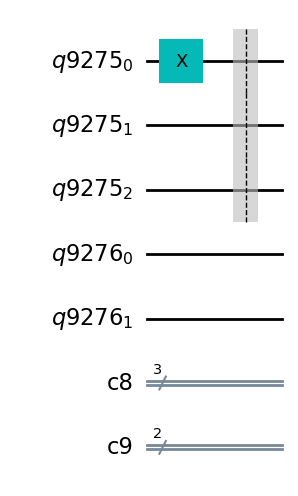

In [221]:
qc_init = build_qc()

qc_init.x(qreg_data[0])
qc_init.barrier(qreg_data)

qc_init.draw(output="mpl")

### Encode our logical state
To protect our qubit we must encode it in the codespace. For the case of the bit-flip code this
is very similar to the repetition code, where we implement repetition using the entangling
`CX` gate rather than a classically conditioned bit-flip as we would do in the classical case.

The encoding circuit below will map $|\Psi_1> = U_{en}|\Psi_0> = |00> (\alpha |000> + \beta |111>)$

The stabilizer for the bit flip code is $S = {III, IZZ, ZIZ, ZZI}$. Operationally what this means is that
a single bit-flip error applied to the qubits will modify the parity of a stabilizer but leave it within the code space. It is also straightforward to show that any two non-trivial Stabilizer elements can generate the full stabilizer. For example taking the generator set $G_0 = \{g_0, g_1 \} = \{ IZZ, ZIZ \}$

We can see this as $g_0g_1 = IZZ . ZIZ = ZZI$ and $g_0g_0 = IZZ.IZZ = III$ completing our Stabilizer.

This means that we must only measure our two generators $g_0$ and $g_1$ to detect any *correctable* error.

It is easy to see the prepared state is a +1 eigenstate of our stabilizers
$IZZ |\Psi_1> = |\Psi_1>$ 
$ZIZ |\Psi_2> = |\Psi_2>$ 

This is because the Stabilizer measures the *parity* of the two target qubits.


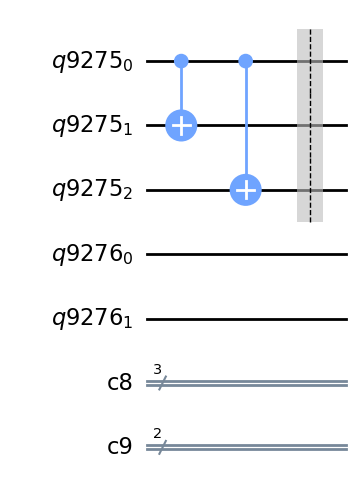

In [222]:
def encode_bit_flip(qc, state, ancillas):
    control = state
    for ancilla in ancillas:
        qc.cx(control, ancilla)
    qc.barrier(state, *ancillas)
    return qc

qc_encode_bit = build_qc()

encode_bit_flip(qc_encode_bit, state_data, ancillas_data)

qc_encode_bit.draw(output="mpl")

However if we consider the action of bit-flip error $X$ which maps $|0> -> |1>$ and $|1> -> |0>$ on any of our qubits we have $\epsilon = \{E_0, E_1, E_2 \} = \{IIX, IXI, XII\}$ 

Evaluating the commutators of our error terms we see:


$$[E_0, g_0] = [IIX, IZZ] = IIX.IZZ - IZZ.IIX \neq 0$$
$$[E_0, g_1] = [IIX, ZIZ] = IIX.ZIZ - IIX.ZIZ \neq 0$$
$$[E_1, g_0] = [IXI, IZZ] = IXI.IZZ - IZZ.IXI \neq 0$$
$$[E_1, g_1] = [IXI, ZIZ] = IXI.ZIZ - IXI.ZIZ = 0$$
$$[E_2, g_0] = [XII, IZZ] = XII.IZZ - IZZ.XII = 0$$
$$[E_2, g_1] = [XII, ZIZ] = XII.ZIZ - XII.ZIZ \neq 0$$

What we see is that if we measure our stabilizers and observe 
$$
Observe
\begin{cases}
<g_0g_1> = 11, \text{Error on qubit 0} \\
<g_0g_1> = 01, \text{Error on qubit 1} \\
<g_0g_1> = 10, \text{Error on qubit 2}
\end{cases}
$$









### Prepare a decoding circuit
To readout our final state we must map it back from the codespace to a single qubit.
For our code this is simply $U_{de} = U_{en}^\dagger$.

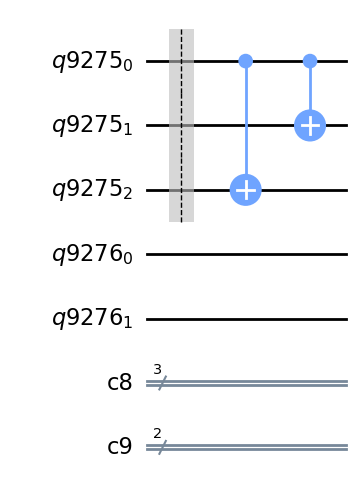

In [223]:
def decode_bit_flip(qc, state, ancillas):
    inv = qc_encode_bit.inverse()
    return qc.compose(inv)

qc_decode_bit = build_qc()

qc_decode_bit = decode_bit_flip(qc_decode_bit, state_data, ancillas_data)

qc_decode_bit.draw(output="mpl")

### A circuit that prepares our encoded state

Below we see how we can combine the state preparation and encoding steps
to encode our state in the bit-flip code.

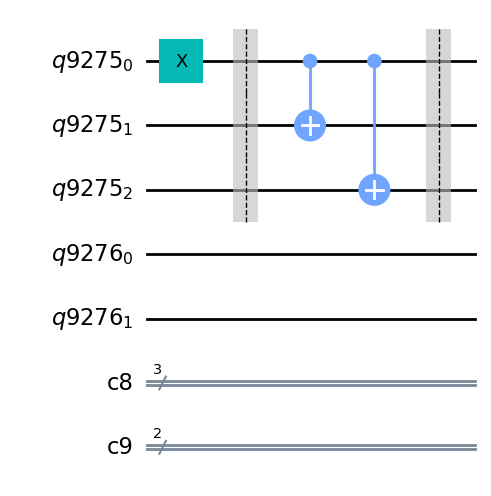

In [224]:
qc_encoded_state_bit = qc_init.compose(qc_encode_bit)
qc_encoded_state_bit.draw(output="mpl")

### Measuring the syndome



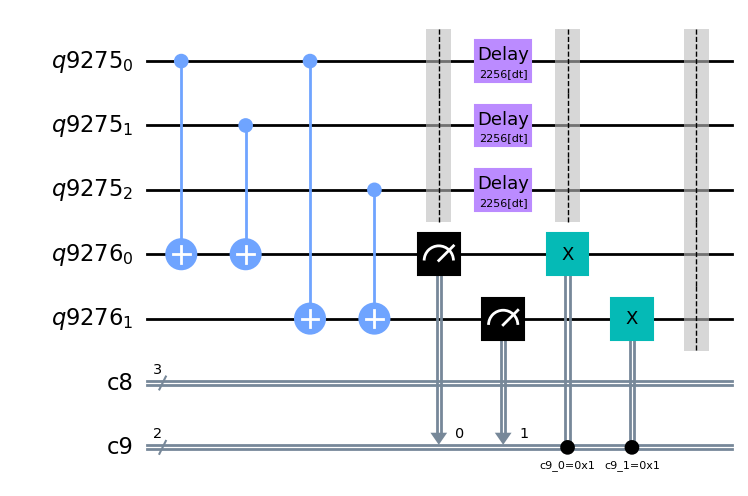

In [225]:
def measure_syndrome_bit(qc, qreg_data, qreg_measure, creg_measure):
    def branch_delay():
        if sim:
            qc.barrier(qreg_data)
            qc.delay(block_branch_cycles, qreg_data)
            qc.barrier(qreg_data)
  
    qc.cx(qreg_data[0], qreg_measure[0])
    qc.cx(qreg_data[1], qreg_measure[0])
    qc.cx(qreg_data[0], qreg_measure[1])
    qc.cx(qreg_data[2], qreg_measure[1])
    qc.measure(qreg_measure, creg_measure)
    branch_delay()
    qc.x(qreg_measure[0]).c_if(creg_measure[0], 1)
    qc.x(qreg_measure[1]).c_if(creg_measure[1], 1)
    qc.barrier(*qreg_data, *qreg_measure)
    return qc

qc_syndrome_bit = measure_syndrome_bit(build_qc(), qreg_data, qreg_measure, creg_syndrome)
qc_syndrome_bit.draw(output="mpl")    

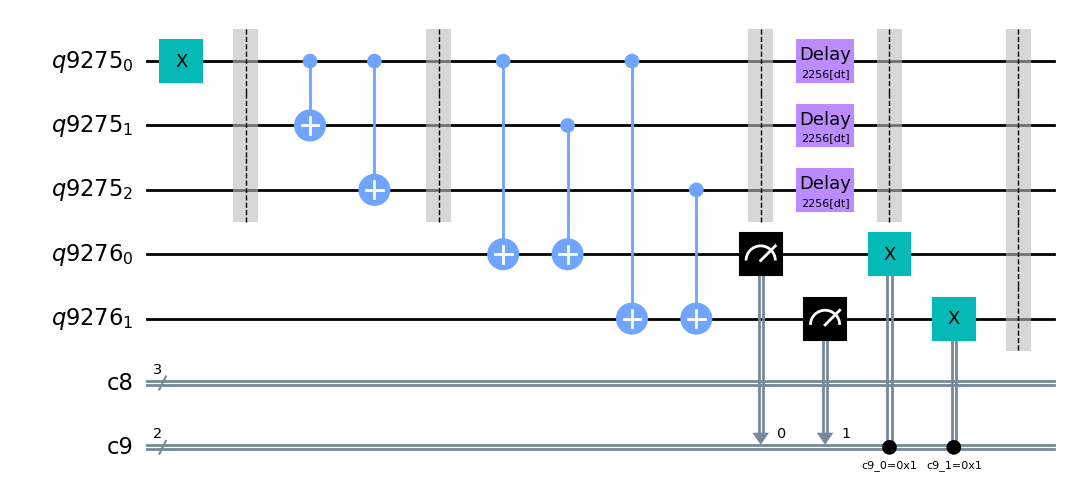

In [226]:
qc_measure_syndrome_bit = qc_encoded_state_bit.compose(qc_syndrome_bit)
qc_measure_syndrome_bit.draw(output="mpl")

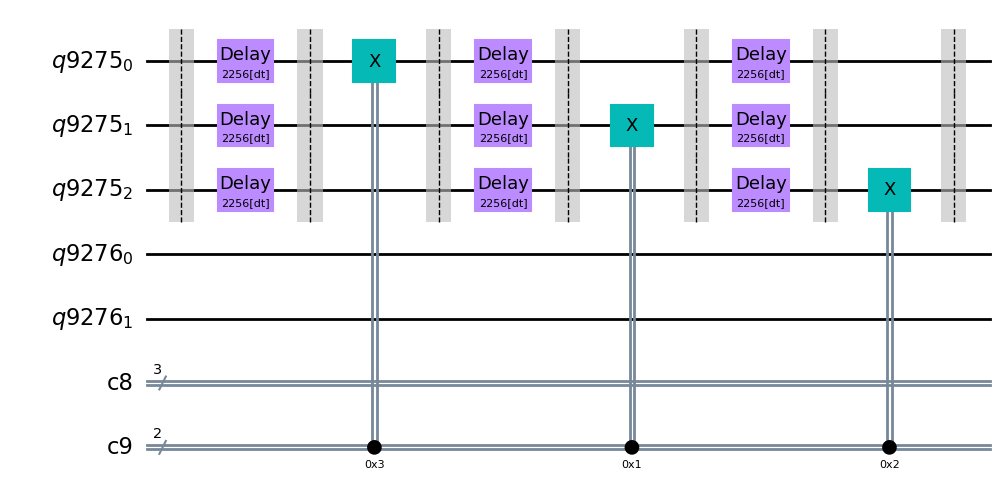

In [227]:
def apply_correction_bit(qc, qreg_data, creg_syndrome):
    # If simulating we need to insert a delay to mirror the hardware
    def branch_delay():
        if sim:
            qc.barrier(qreg_data)
            qc.delay(block_branch_cycles, qreg_data)
            qc.barrier(qreg_data)
    
    branch_delay()
    qc.x(qreg_data[0]).c_if(creg_syndrome, 3)
    branch_delay()
    qc.x(qreg_data[1]).c_if(creg_syndrome, 1)
    branch_delay()
    qc.x(qreg_data[2]).c_if(creg_syndrome, 2)
    qc.barrier(qreg_data)
    return qc
    
qc_correction_bit = apply_correction_bit(build_qc(), qreg_data, creg_syndrome)
qc_correction_bit.draw(output="mpl")

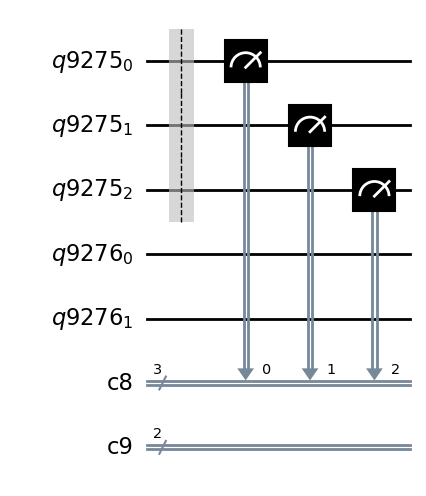

In [228]:
def apply_final_readout(qc, qreg_data, creg_data):
    """Apply inverse mapping so that we always try and measure |1> in the computational basis.
    
    TODO: The above is just a stand in for proper measurement basis measurement
    """
    qc.barrier(qreg_data)
    qc.measure(qreg_data, creg_data)
    return qc

qc_final_measure = apply_final_readout(build_qc(), qreg_data, creg_data)
qc_final_measure.draw(output="mpl")

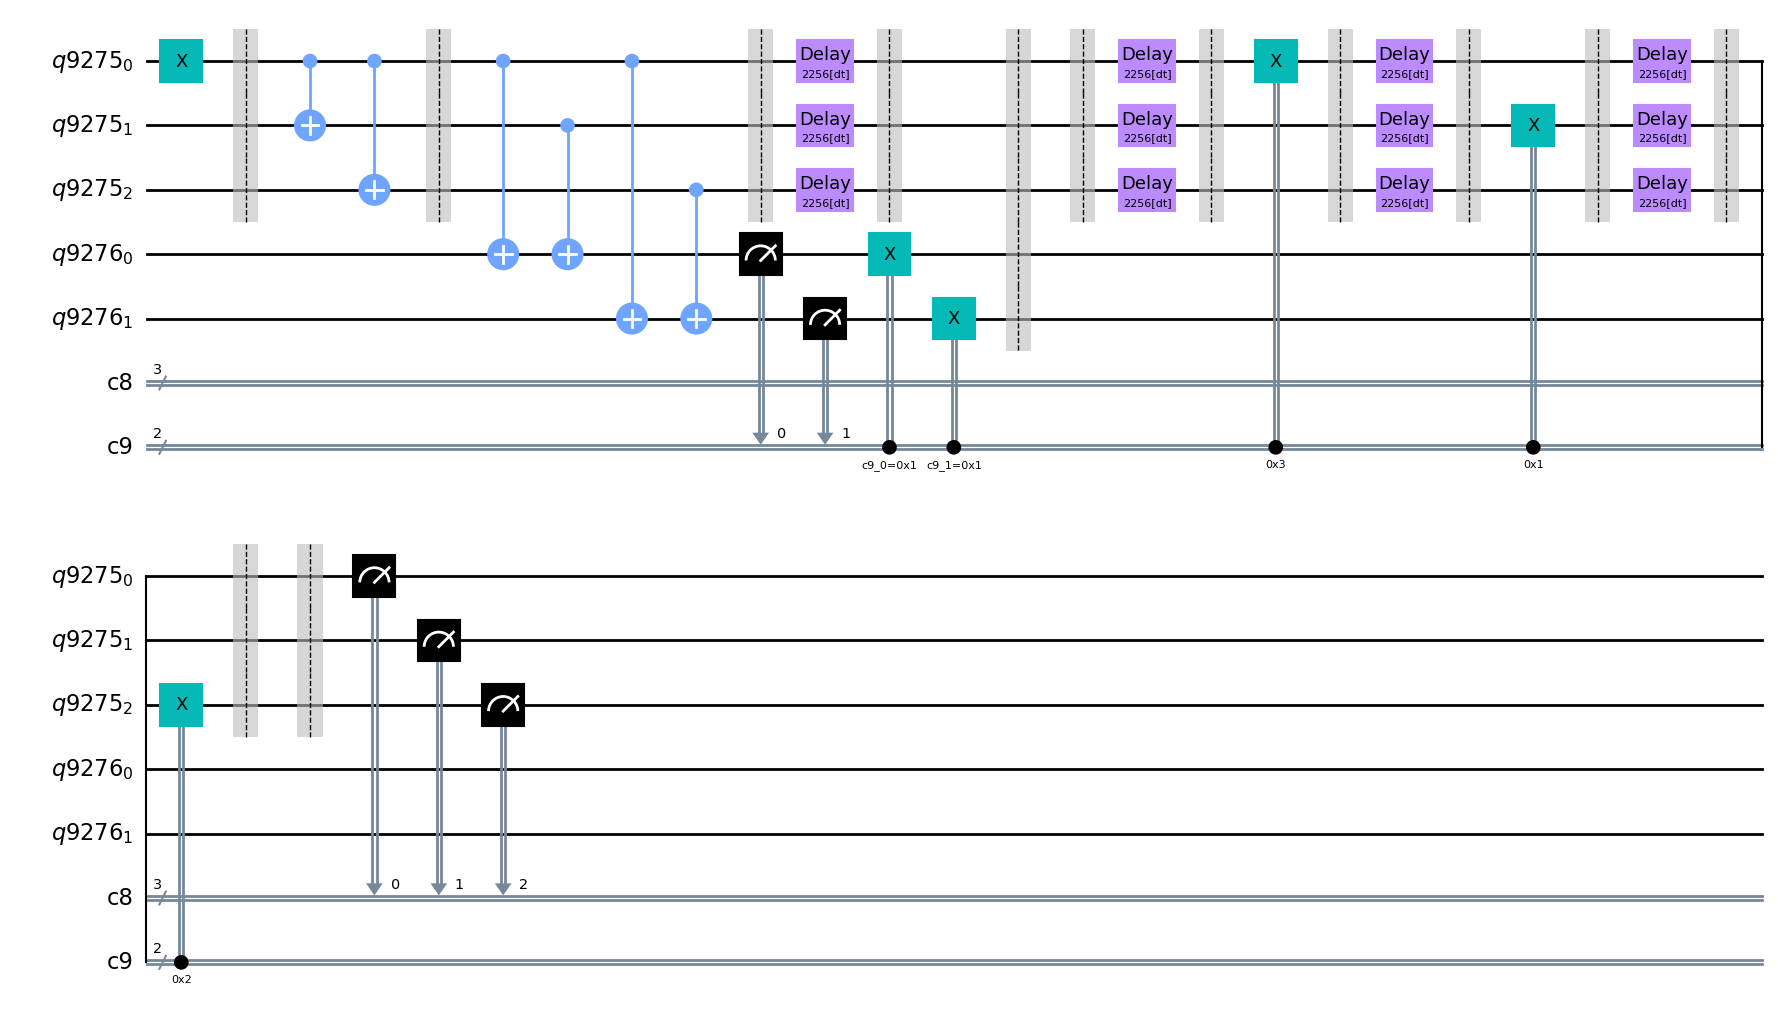

In [229]:
bit_code_circuit = qc_measure_syndrome_bit.compose(qc_correction_bit).compose(qc_final_measure)
bit_code_circuit.draw(output="mpl")

In [230]:
favourite_qubits = [5, 3, 8, 2, 9] # A candidate initial layout

# Approximate duration of the measurement processing / conditional latency
block_branch_duration = 0.5e-6 
block_branch_cycles = convert_cycles(block_branch_duration, backend)

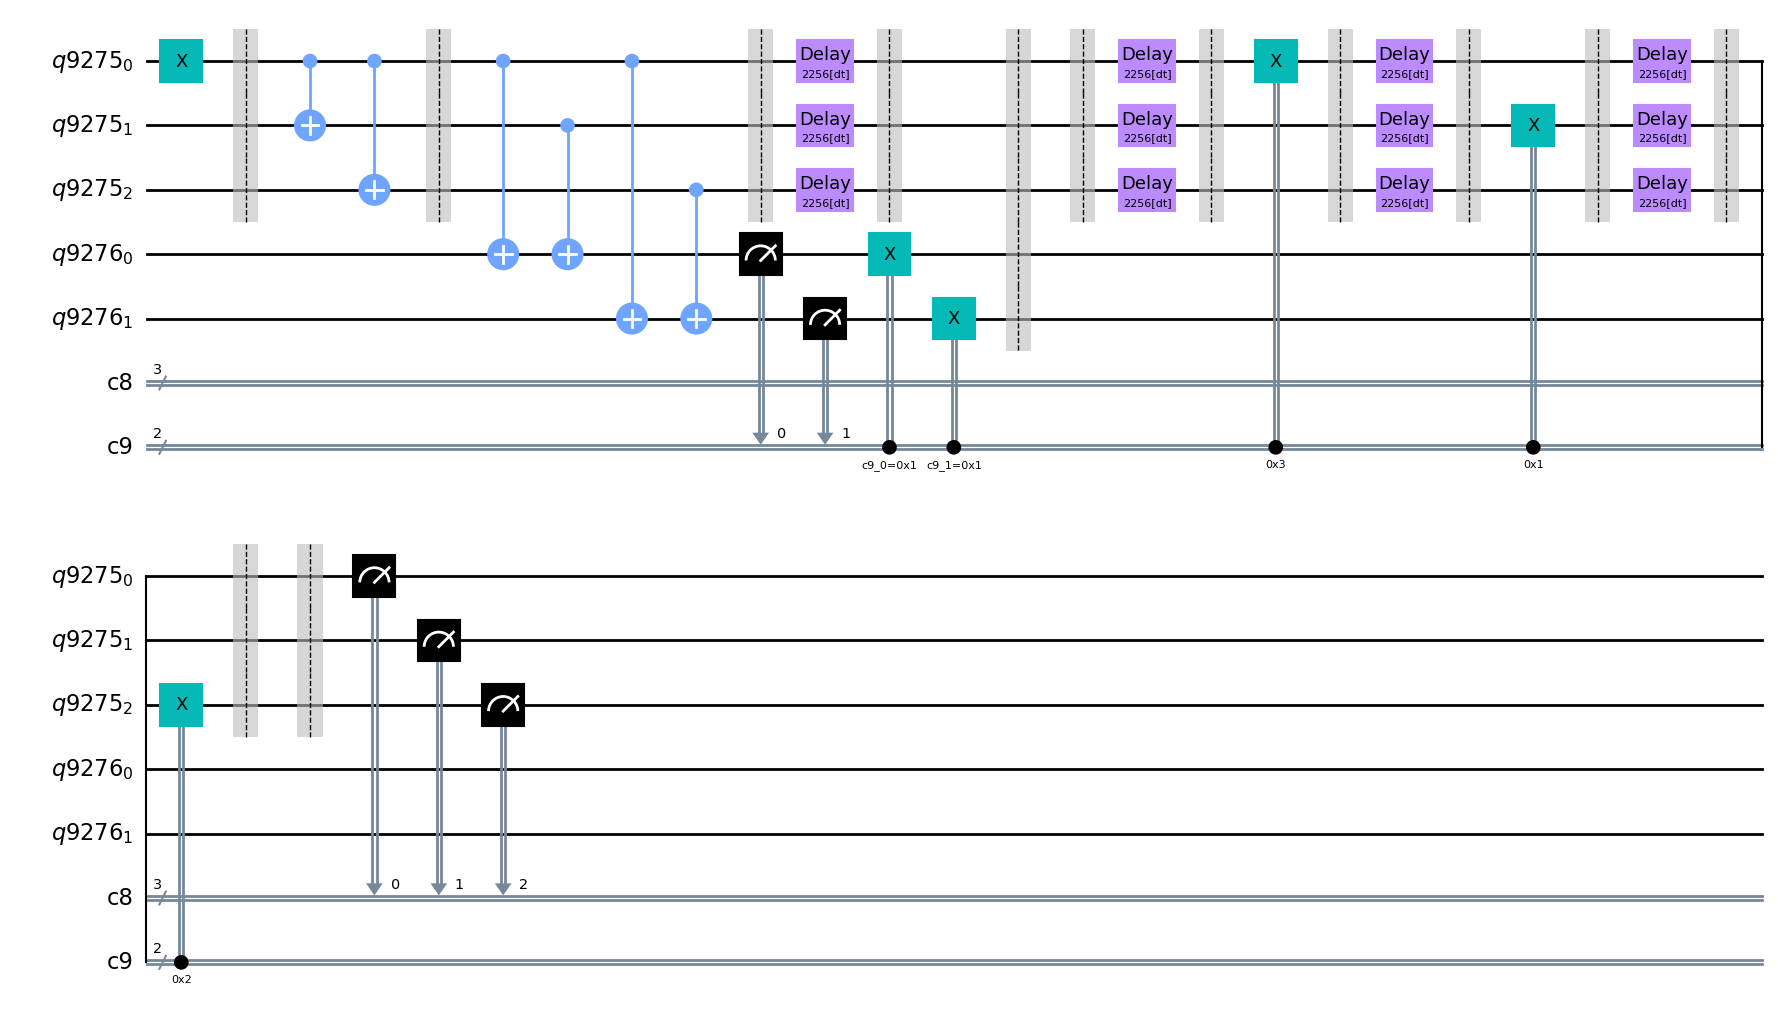

In [231]:
def build_error_correction_sequence(
    qc_base: QuantumCircuit,
    qc_init: Optional[QuantumCircuit], 
    qc_encode: QuantumCircuit, 
    qc_channels: List[QuantumCircuit],
    qc_syndrome: QuantumCircuit,
    qc_correct: QuantumCircuit,
    qc_decode: Optional[QuantumCircuit] = None,
    qc_final: Optional[QuantumCircuit] = None,
    name=None,
) -> QuantumCircuit:
    """Build a typical error correction circuit"""
    qc = qc_base
    
    if qc_init:
        qc = qc.compose(
            qc_init
        )
    
    qc = qc.compose(
            qc_encode
        )
    if name is not None:
        qc.name = name
    
    if not qc_channels:
        qc_channels = [QuantumCircuit(*qc.qregs)]
        
    for qc_channel in qc_channels:
        qc = qc.compose(
                qc_channel
            ).compose(
                qc_syndrome
            ).compose(
                qc_correct
            )
    if qc_decode:
        qc = qc.compose(qc_decode)
    
    if qc_final:
        qc = qc.compose(qc_final_measure)
    
    return qc


bit_code_circuit = build_error_correction_sequence(
    build_qc(),
    qc_init,
    qc_encode_bit,
    [],
    qc_syndrome_bit,
    qc_correction_bit,
    None,
    qc_final_measure,
)
bit_code_circuit.draw(output="mpl")

### Running on Hardware

In [232]:
layout_circuit = transpile(bit_code_circuit, backend, optimization_level=3)
print(initial_layout := calculate_initial_layout(layout_circuit, False, favourite_qubits))

[5, 3, 8, 2, 9]


In [233]:
transpiled_bit_code_circuit = apply_transpile(bit_code_circuit, backend, initial_layout=initial_layout)

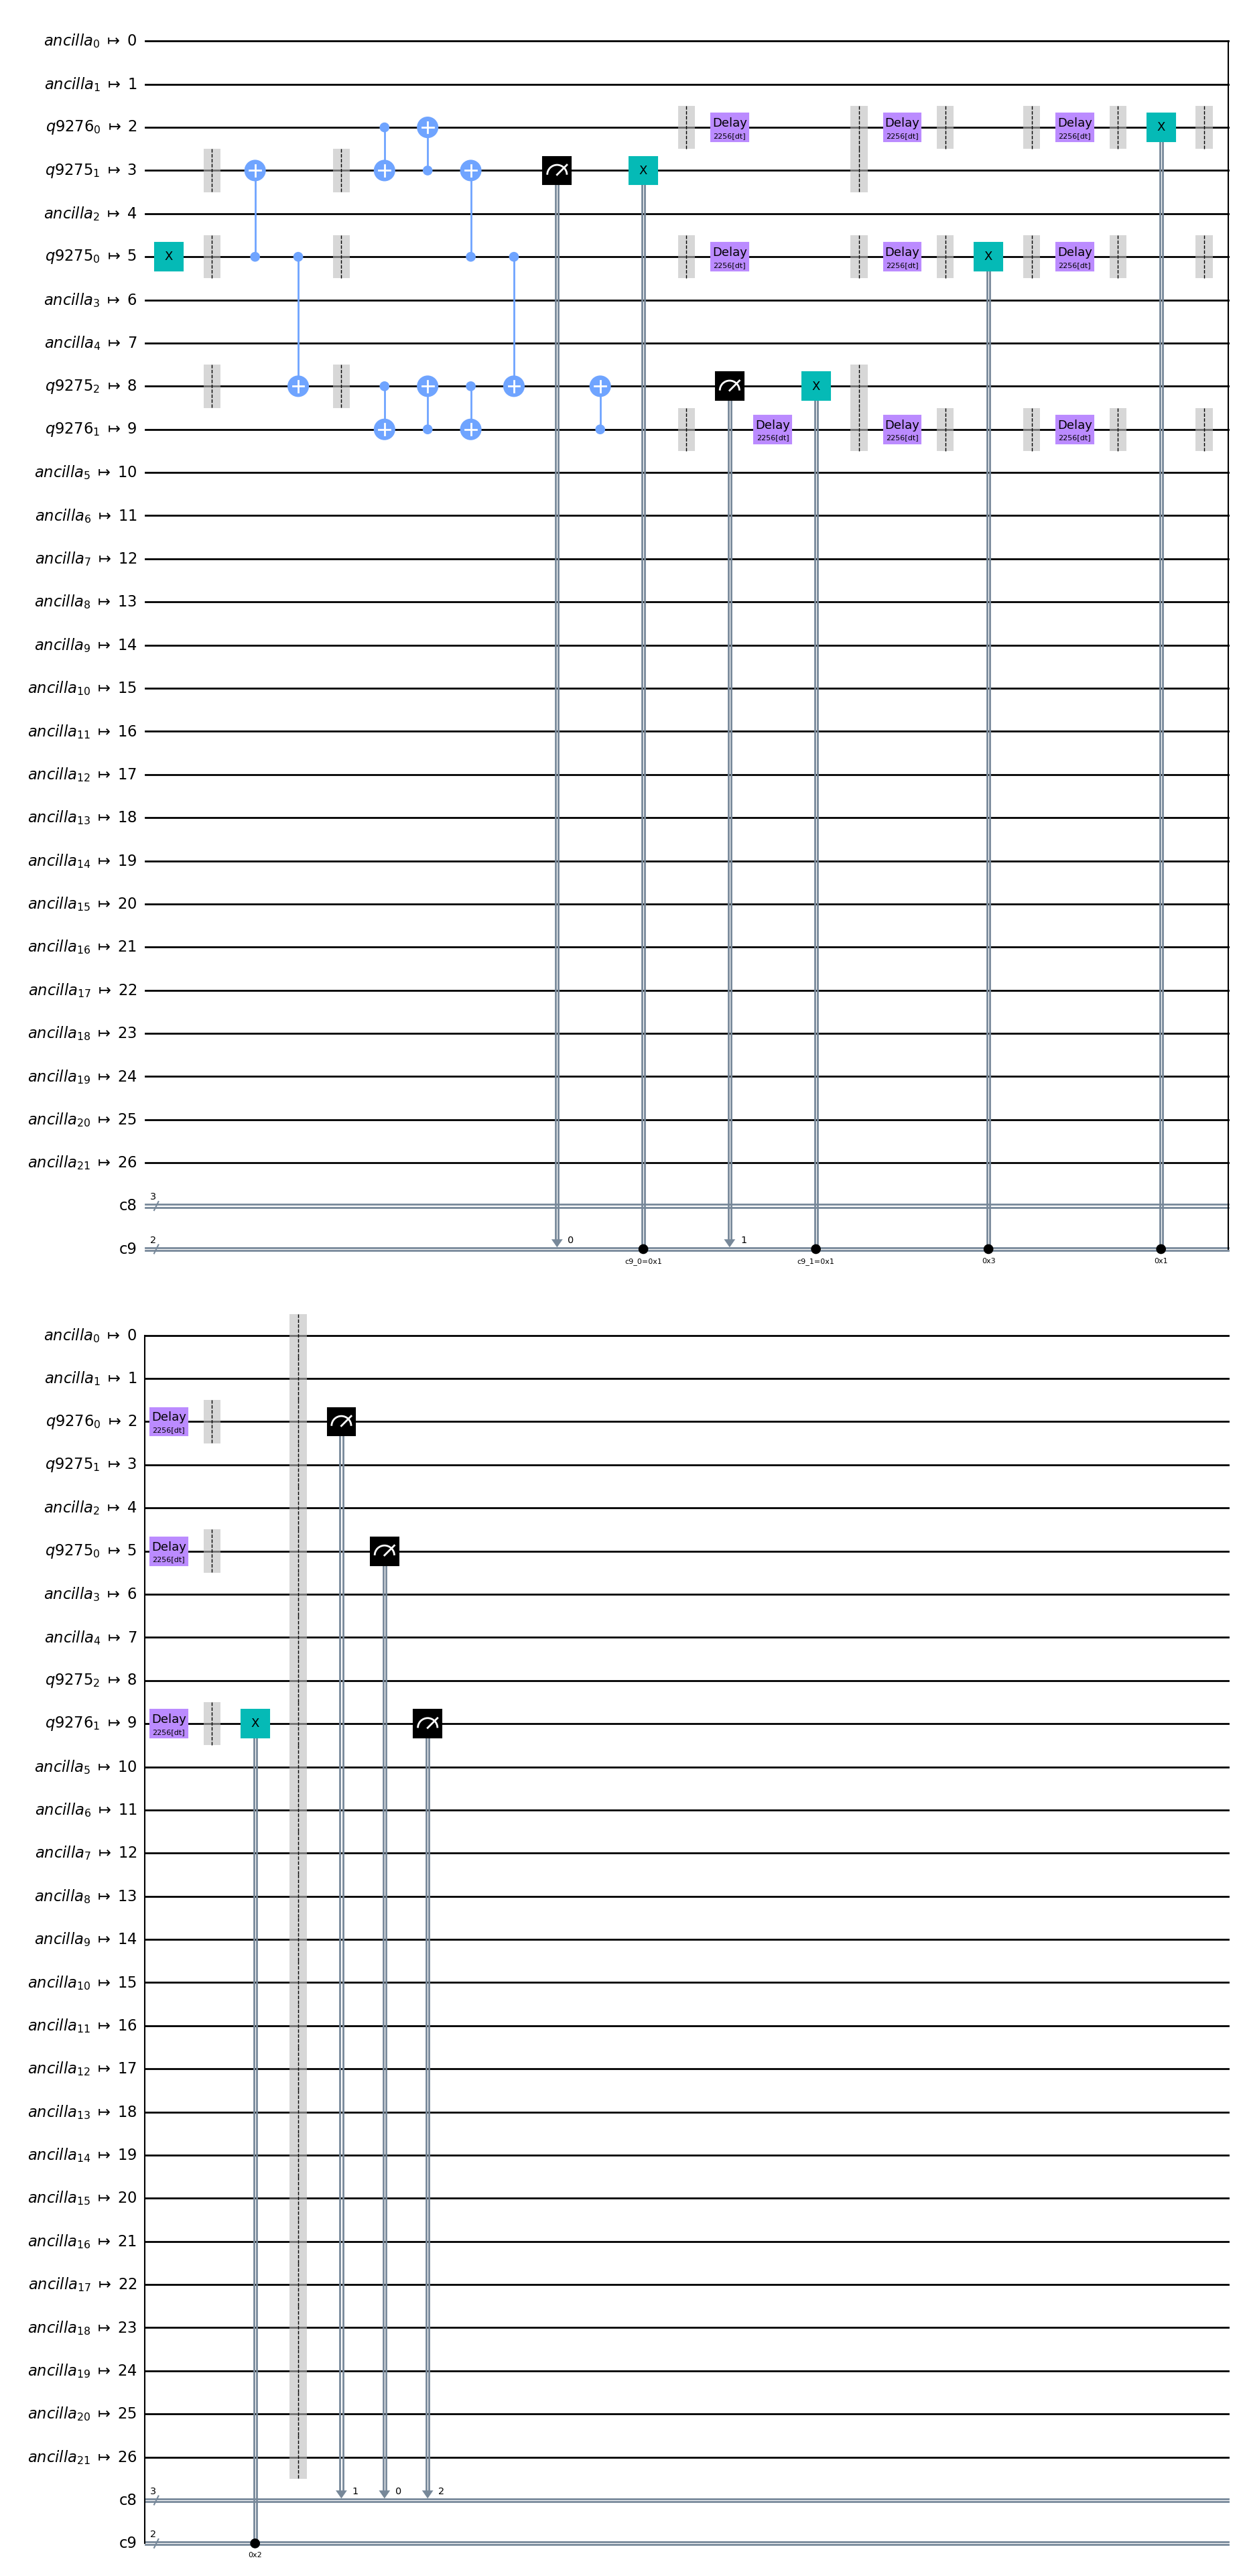

In [234]:
transpiled_bit_code_circuit.draw(output="mpl")

In [235]:
result = execute(transpiled_bit_code_circuit).result()

data_indices = list(range(len(qreg_data)))
syndrome_indices = list(range(data_indices[-1]+1, len(qreg_data) + len(qreg_measure) ))
                    
marginalized_data_result = marginal_counts(result, data_indices)
marginalized_syndrome_result = marginal_counts(result, syndrome_indices)

print(f'Completed bit code experiment data measurement counts {marginalized_data_result.get_counts(0)}')
print(f'Completed bit code experiment syndrome measurement counts {marginalized_syndrome_result.get_counts(0)}')

Completed bit code experiment data measurement counts {'001': 6, '100': 5, '000': 1000, '010': 13}
Completed bit code experiment syndrome measurement counts {'00': 1010, '01': 9, '10': 5}


In [236]:
def decode_result(data_counts, syndrome_counts, verbose=True, indent=0):
    shots = sum(data_counts.values())
    success_trials = data_counts.get('000', 0) + data_counts.get('111', 0)
    failed_trials = shots-success_trials
    error_correction_events = shots-syndrome_counts.get('00', 0)
    
    if verbose:
        print(f"{' ' * indent}Bit flip errors were corrected on {error_correction_events}/{shots} trials")
        print(f"{' ' * indent}A final parity error was detected on {failed_trials}/{shots} trials")
        print(f"{' ' * indent}No error was detected on {success_trials}/{shots} trials")
    return error_correction_events, failed_trials

decode_result(marginalized_data_result.get_counts(0), marginalized_syndrome_result.get_counts(0));

Bit flip errors were corrected on 14/1024 trials
A final parity error was detected on 24/1024 trials
No error was detected on 1000/1024 trials


## Let's emulate a random error source
Here we will use some more control flow to insert a random bit-flip error by using an ancilla qubit as a source of random bit flips.

In [237]:
from qiskit.circuit.library import IGate, XGate, ZGate

qreg_error_ancilla = QuantumRegister(1)
creg_error_ancilla = ClassicalRegister(1)

def build_random_error_channel(gate, ancilla, creg_ancilla, error_qubit):
    """Build an error channel that randomly applies a single-qubit gate based on an ancilla qubit measurement result"""
    qc = build_qc()
    qc.add_register(qreg_error_ancilla)
    qc.add_register(creg_error_ancilla)
    qc.barrier(ancilla, error_qubit.register)
    # 50-50 chance of applying a bit-flip
    qc.h(ancilla)
    qc.measure(ancilla, creg_ancilla)
    qc.append(gate, [error_qubit]).c_if(creg_ancilla, 1)
    qc.barrier(ancilla, error_qubit.register)
    return qc

qc_id_error_channel = build_random_error_channel(IGate(), qreg_error_ancilla, creg_error_ancilla, qreg_data[0])
print("Identity error channel")
print(qc_id_error_channel.draw(idle_wires=False))

qc_bit_flip_error_channel = build_random_error_channel(XGate(), qreg_error_ancilla, creg_error_ancilla, qreg_data[0])
print("Bit flip error channel")
print(qc_bit_flip_error_channel.draw(idle_wires=False))

qc_phase_flip_error_channel = build_random_error_channel(ZGate(), qreg_error_ancilla, creg_error_ancilla, qreg_data[0])
print("Phase flip error channel")
print(qc_phase_flip_error_channel.draw(idle_wires=False))

Identity error channel
          ░          ┌───┐  ░ 
q9275_0: ─░──────────┤ I ├──░─
          ░ ┌───┐┌─┐ └─╥─┘  ░ 
  q9379: ─░─┤ H ├┤M├───╫────░─
          ░ └───┘└╥┘┌──╨──┐ ░ 
  c10: 1/═════════╩═╡ 0x1 ╞═══
                  0 └─────┘   
Bit flip error channel
          ░          ┌───┐  ░ 
q9275_0: ─░──────────┤ X ├──░─
          ░ ┌───┐┌─┐ └─╥─┘  ░ 
  q9379: ─░─┤ H ├┤M├───╫────░─
          ░ └───┘└╥┘┌──╨──┐ ░ 
  c10: 1/═════════╩═╡ 0x1 ╞═══
                  0 └─────┘   
Phase flip error channel
          ░          ┌───┐  ░ 
q9275_0: ─░──────────┤ Z ├──░─
          ░ ┌───┐┌─┐ └─╥─┘  ░ 
  q9379: ─░─┤ H ├┤M├───╫────░─
          ░ └───┘└╥┘┌──╨──┐ ░ 
  c10: 1/═════════╩═╡ 0x1 ╞═══
                  0 └─────┘   


Let us now add our error channel in between our syndrome measurement and decode/correct phase

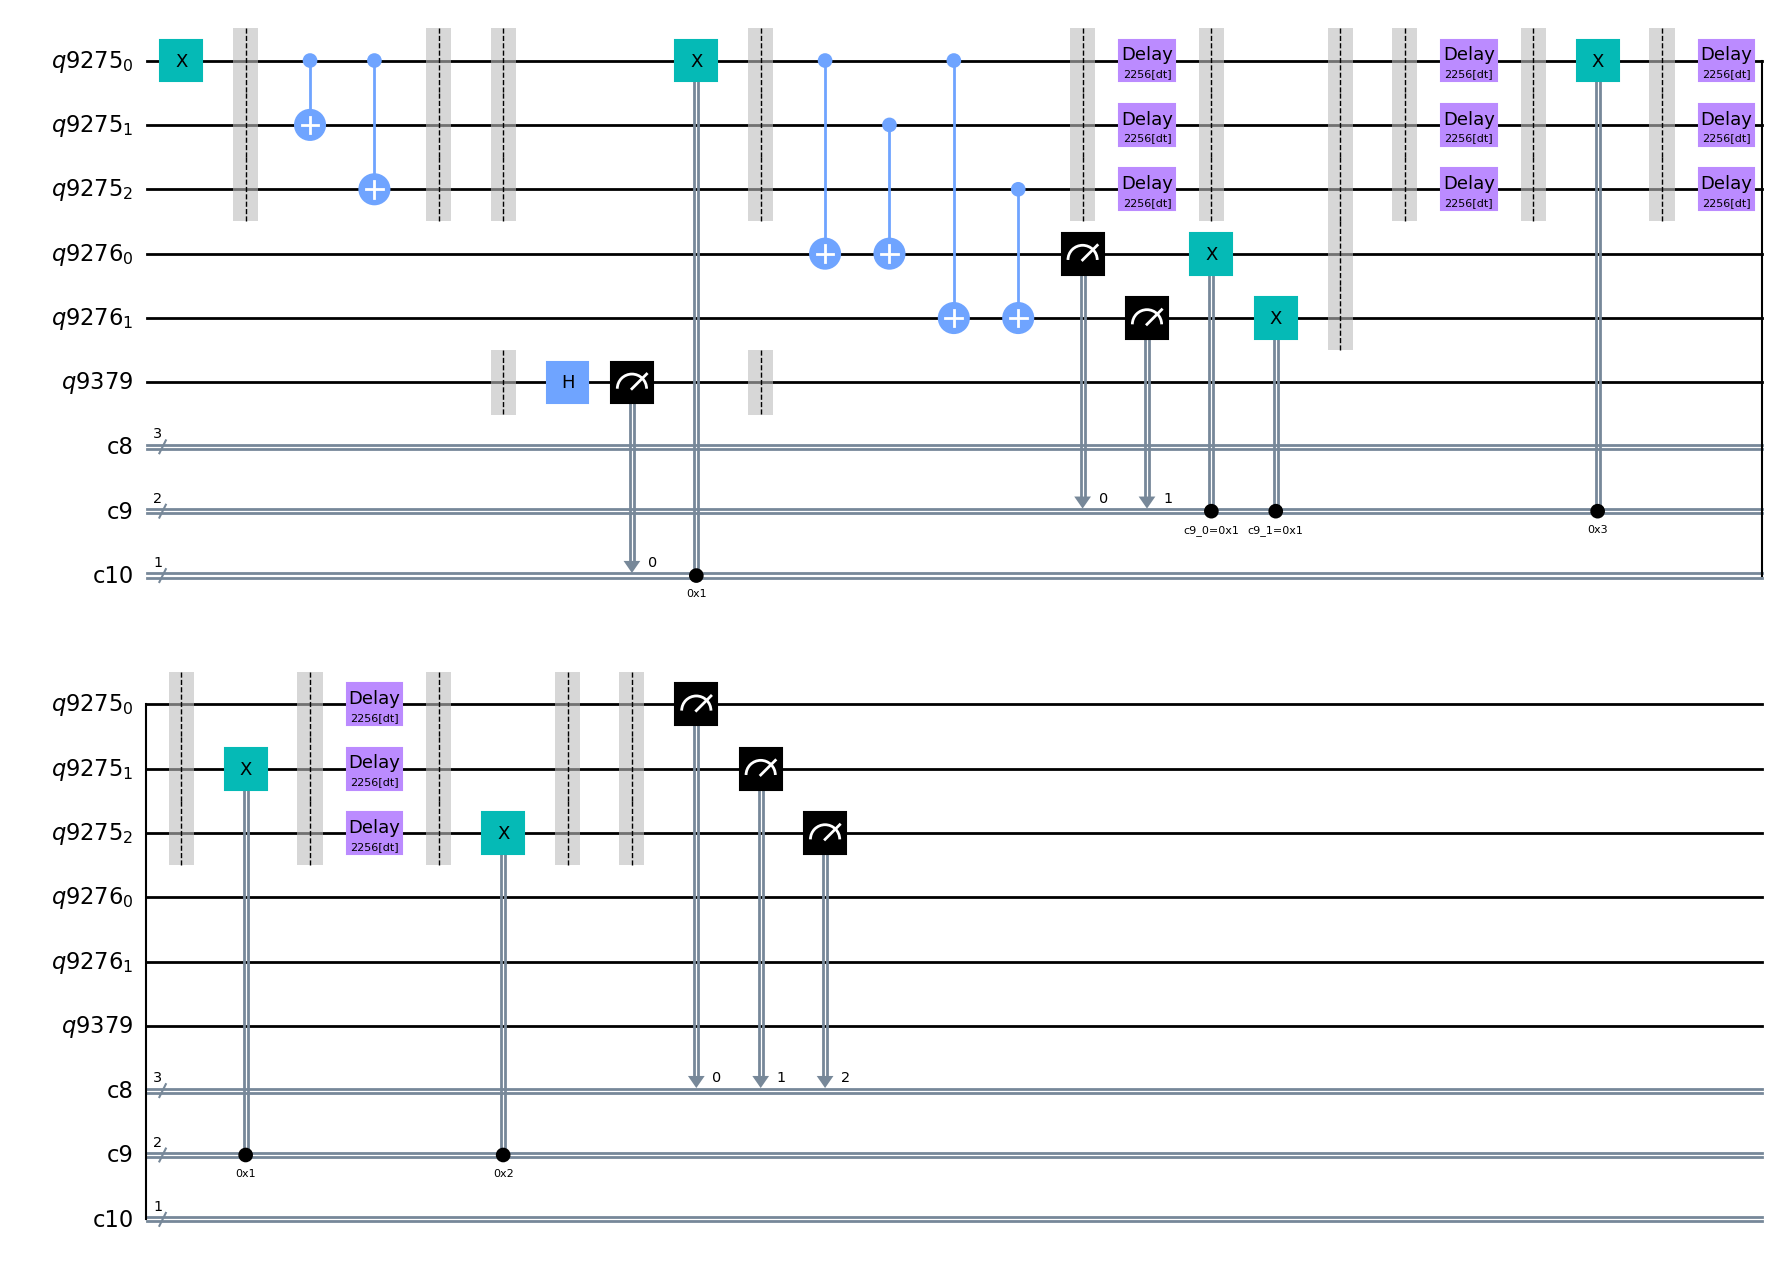

In [238]:
def build_error_channel_base():
    qc = build_qc()
    qc.add_register(qreg_error_ancilla)
    qc.add_register(creg_error_ancilla)
    return qc

qc_id_error_bit_flip_code = build_error_correction_sequence(
    build_error_channel_base(),
    qc_init,
    qc_encode_bit,
    [qc_id_error_channel],
    qc_syndrome_bit,
    qc_correction_bit,
    None,
    qc_final_measure,
    "Identity error channel"
)

qc_bit_flip_error_bit_flip_code = build_error_correction_sequence(
    build_error_channel_base(),
    qc_init,
    qc_encode_bit,
    [qc_bit_flip_error_channel],
    qc_syndrome_bit,
    qc_correction_bit,
    None,
    qc_final_measure,
    "Bit flip error channel"
)

qc_phase_flip_error_bit_flip_code = build_error_correction_sequence(
    build_error_channel_base(),
    qc_init,
    qc_encode_bit,
    [qc_phase_flip_error_channel],
    qc_syndrome_bit,
    qc_correction_bit,
    None,
    qc_final_measure,
    "Phase flip error channel"
)

circuits_error_channels_bit_flip_code = [qc_id_error_bit_flip_code, qc_bit_flip_error_bit_flip_code, qc_phase_flip_error_bit_flip_code]

qc_bit_flip_error_bit_flip_code.draw(output="mpl")

In [239]:
# We need to add an extra ancilla qubit to our layout
# It doesn't matter which qubit for the must part as we are using as a
# source of random information
error_channel_layout = error_channel_layout = initial_layout + list(set(range(circuits_error_channels_bit_flip_code[0].num_qubits)) - set(initial_layout))[:1]

transpiled_circuits_error_channels_bit_flip_code = apply_transpile(circuits_error_channels_bit_flip_code, backend, initial_layout=error_channel_layout)
result_error_channels_bit_flip_code = execute(transpiled_circuits_error_channels_bit_flip_code).result()

In [240]:
from qiskit.quantum_info.analysis import hellinger_fidelity

def decode_error_channel_result(qc_init, data_counts, syndrome_counts, verbose=True, indent=0):
    shots = sum(data_counts.values())
    logical_zero = data_counts.get('000', 0)
    logical_one = data_counts.get('111', 0)
    success_trials = logical_zero + logical_one
    failed_trials = shots-success_trials
    logical_counts = {"0": logical_zero, "1": logical_one}
    
    
    ideal_transpiled = apply_transpile(qc_init_outcome, backend, initial_layout)
    counts_ideal = marginal_counts(ideal_sim.run(ideal_transpiled, shots=success_trials).result().get_counts(0), indices=[0])
    
    fidelity = hellinger_fidelity(counts_ideal, logical_counts)
    
    error_correction_events = shots-syndrome_counts.get('00', 0)
    
    if verbose:
        print(f"{' ' * indent}Bit flip errors were corrected on {error_correction_events}/{shots} trials")
        print(f"{' ' * indent}A final parity error was detected on {failed_trials}/{shots} trials")
        print(f"{' ' * indent}For the successful trials the Hellinger fidelity is {fidelity}")
    return error_correction_events, failed_trials

In [241]:
qc_init_outcome = qc_init.copy()
qc_init_outcome.measure(qreg_data[0], 0)

qreg_indices = list(range(len(qreg_data)))
data_indices = qreg_indices[:1]
syndrome_indices = list(range(qreg_indices[-1]+1, len(qreg_data) + len(qreg_measure) ))

result_decoded_data_qubit_marginal_err_ch = marginal_counts(result_error_channels_bit_flip_code, data_indices)
result_data_marginal_err_ch = marginal_counts(result_error_channels_bit_flip_code, qreg_indices)
result_syndrome_marginal_err_ch = marginal_counts(result_error_channels_bit_flip_code, syndrome_indices)

for i, qc in enumerate(transpiled_circuits_error_channels_bit_flip_code):
    print(f"For {qc.name} with bit flip code")
    print(f'    Completed bit code experiment decoded data qubit measurement counts {result_decoded_data_qubit_marginal_err_ch.get_counts(i)}')
    print(f'    Completed bit code experiment data qubits measurement counts {result_data_marginal_err_ch.get_counts(i)}')
    print(f'    Completed bit code experiment syndrome measurement counts {result_data_marginal_err_ch.get_counts(i)}')
    decode_error_channel_result(qc_init_outcome, result_data_marginal_err_ch.get_counts(i), result_syndrome_marginal_err_ch.get_counts(i), indent=4);
    print("")

For Identity error channel with bit flip code
    Completed bit code experiment decoded data qubit measurement counts {'1': 3, '0': 1021}
    Completed bit code experiment data qubits measurement counts {'001': 3, '100': 3, '000': 1008, '010': 10}
    Completed bit code experiment syndrome measurement counts {'001': 3, '100': 3, '000': 1008, '010': 10}
    Bit flip errors were corrected on 13/1024 trials
    A final parity error was detected on 16/1024 trials
    For the successful trials the Hellinger fidelity is 0.0

For Bit flip error channel with bit flip code
    Completed bit code experiment decoded data qubit measurement counts {'0': 1023, '1': 1}
    Completed bit code experiment data qubits measurement counts {'000': 1010, '001': 1, '100': 5, '010': 8}
    Completed bit code experiment syndrome measurement counts {'000': 1010, '001': 1, '100': 5, '010': 8}
    Bit flip errors were corrected on 12/1024 trials
    A final parity error was detected on 14/1024 trials
    For the s

# Exercises
Now we will complete several exercises that build on the code above.

We will aim to evaluate the bit-flip code.

## Exercise #1 - Compare our bit-flip code with a code that applies the "identity" correction

Complete the method below ``apply_no_correction_bit`` to create a decoding sequence
that *does not* correct the error but rather performs conditional identity operations

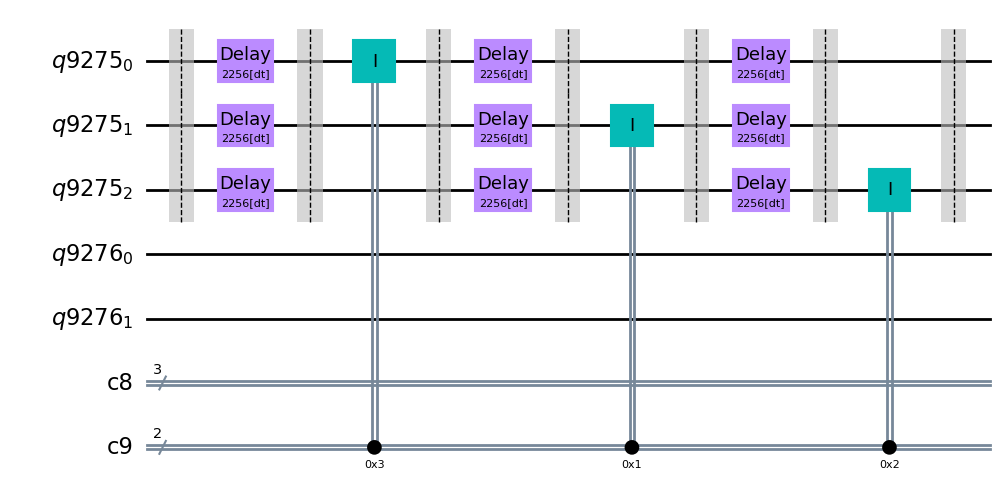

In [242]:
def apply_no_correction_bit(qc, qreg_data, creg_syndrome):
    """Complete the method below to apply an "identity correction"
    
    Make sure to still apply the conditional gates so that the comparison to the bit-flip
    code is faithful.
    """
    # If simulating we should insert a delay to mirror the hardware
    def branch_delay():
        if sim:
            qc.barrier(qreg_data)
            qc.delay(block_branch_cycles, qreg_data)
            qc.barrier(qreg_data)
    branch_delay()
    qc.id(qreg_data[0]).c_if(creg_syndrome, 3)
    branch_delay()
    qc.id(qreg_data[1]).c_if(creg_syndrome, 1)
    branch_delay()
    qc.id(qreg_data[2]).c_if(creg_syndrome, 2)
    qc.barrier(qreg_data)
    return qc

    
qc_no_correction_bit = apply_no_correction_bit(build_qc(), qreg_data, creg_syndrome)
qc_no_correction_bit.draw(output="mpl")

Complete the methods below similar to `qc_id_error_bit_flip_code` above
to implement circuits that *do not* correct the bit flip errors, using your routine above.

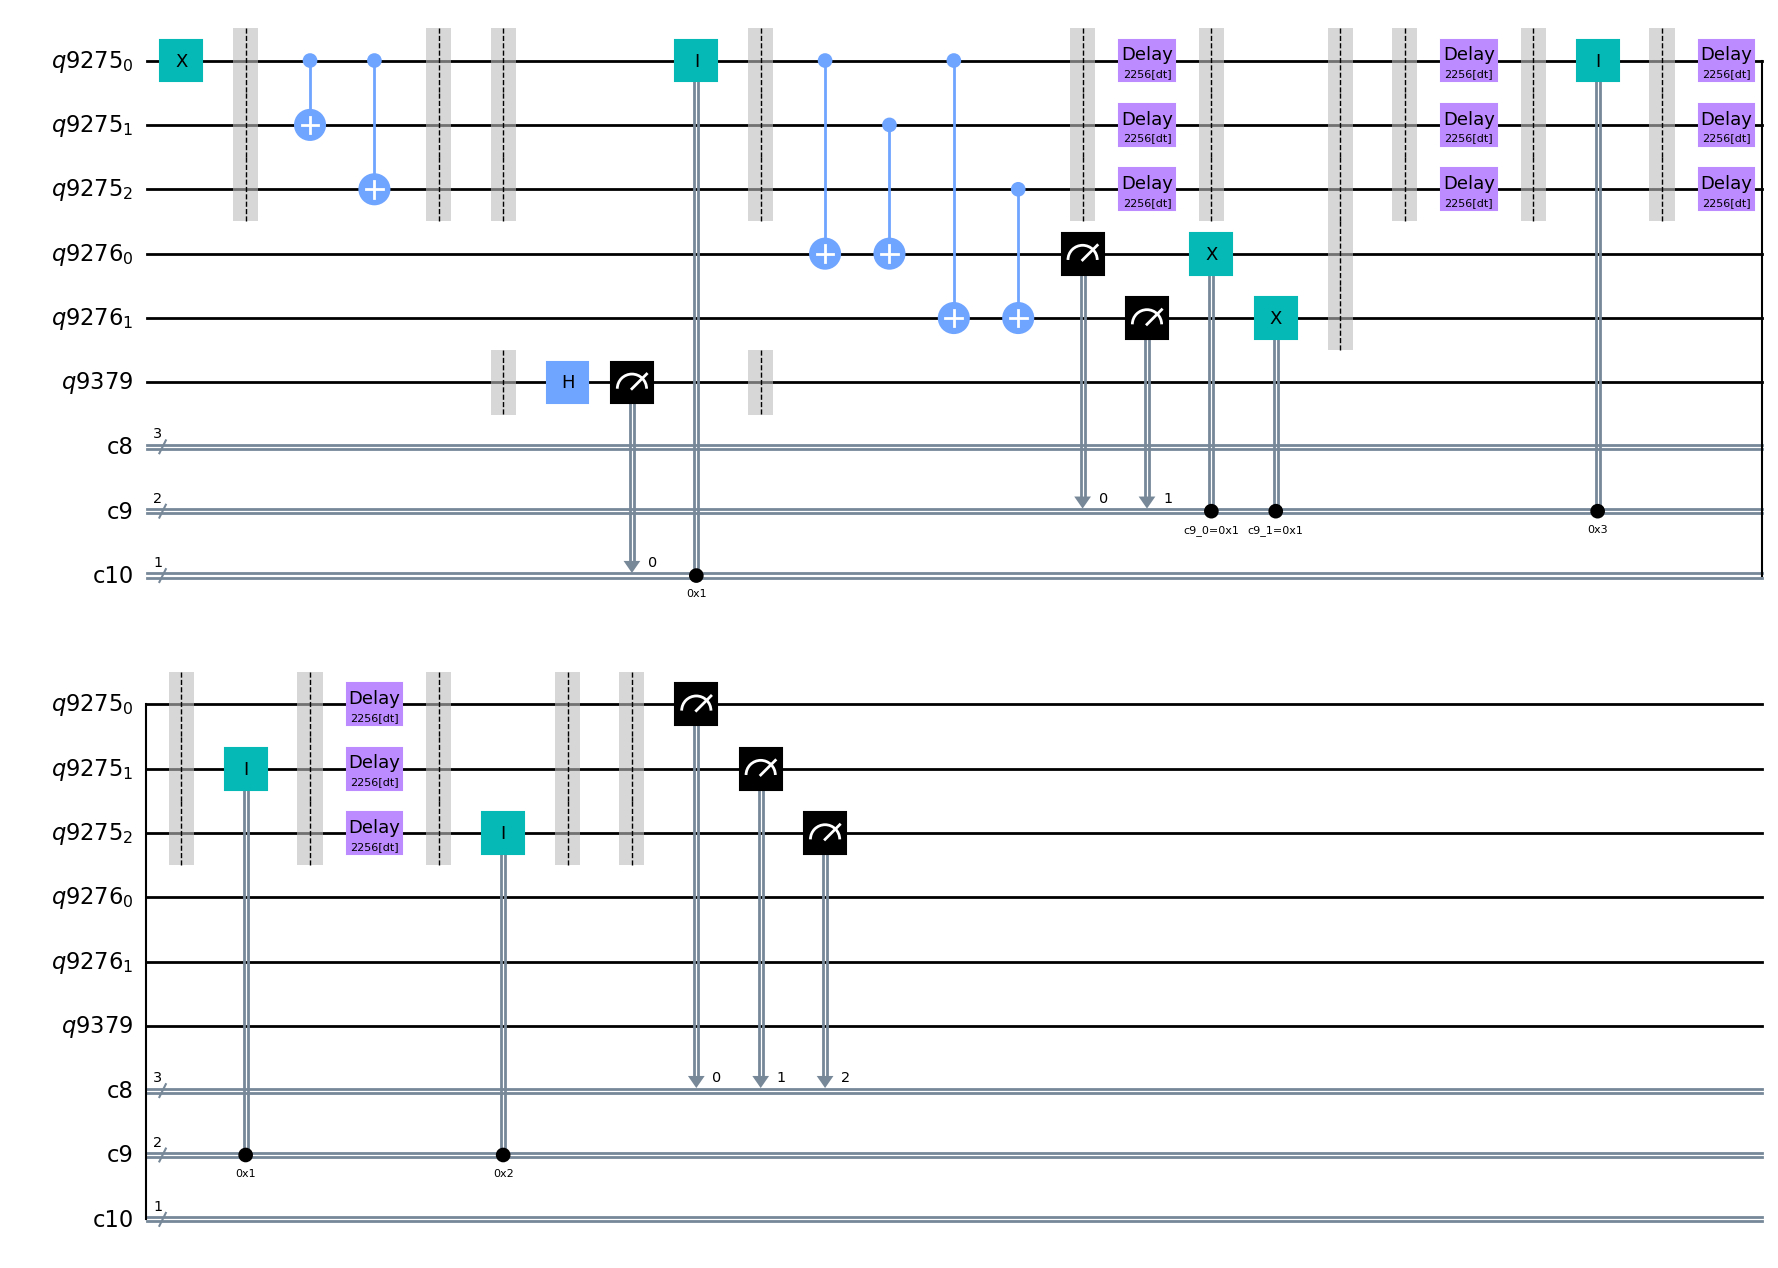

In [243]:
qc_id_error_no_correct = QuantumCircuit() # build_error_correction_sequence(...)
qc_bit_flip_error_no_correct = QuantumCircuit() # build_error_correction_sequence(...)
qc_phase_flip_error_no_correct = QuantumCircuit() # build_error_correction_sequence(...)

qc_id_error_no_correct = build_error_correction_sequence(
    build_error_channel_base(),
    qc_init,
    qc_encode_bit,
    [qc_id_error_channel],
    qc_syndrome_bit,
    qc_no_correction_bit,
    None,
    qc_final_measure,
    "Identity error channel"
)

qc_bit_flip_error_no_correct = build_error_correction_sequence(
    build_error_channel_base(),
    qc_init,
    qc_encode_bit,
    [qc_bit_flip_error_channel],
    qc_syndrome_bit,
    qc_no_correction_bit,
    None,
    qc_final_measure,
    "Bit flip error channel"
)

qc_phase_flip_error_no_correct = build_error_correction_sequence(
    build_error_channel_base(),
    qc_init,
    qc_encode_bit,
    [qc_phase_flip_error_channel],
    qc_syndrome_bit,
    qc_no_correction_bit,
    None,
    qc_final_measure,
    "Phase flip error channel"
)

circuits_error_channels_no_correct = [qc_id_error_no_correct, qc_bit_flip_error_no_correct, qc_phase_flip_error_no_correct]

qc_id_error_no_correct.draw(output="mpl")

Execute the circuits you created that *do not* perform a correction

In [244]:
# We need to add an extra ancilla qubit to our layout
# It doesn't matter which qubit for the must part as we are using as a
# source of random information
error_channel_layout = error_channel_layout = initial_layout + list(set(range(circuits_error_channels_bit_flip_code[0].num_qubits)) - set(initial_layout))[:1]

transpiled_circuits_error_channels_no_correct = apply_transpile(circuits_error_channels_no_correct, backend, initial_layout=error_channel_layout)
result_error_channels_no_correct = execute(transpiled_circuits_error_channels_no_correct).result()

Analyze how well these circuits performed. Is the result worse than that of the corrected bit-flip code?

In [245]:
qc_init_outcome = qc_init.copy()
qc_init_outcome.measure(qreg_data[0], 0)

qreg_indices = list(range(len(qreg_data)))
data_indices = qreg_indices[:1]
syndrome_indices = list(range(qreg_indices[-1]+1, len(qreg_data) + len(qreg_measure) ))

result_decoded_data_qubit_marginal_no_correct = marginal_counts(result_error_channels_no_correct, data_indices)
result_data_marginal_no_correct = marginal_counts(result_error_channels_no_correct, qreg_indices)
result_syndrome_marginal_no_correct = marginal_counts(result_error_channels_no_correct, syndrome_indices)

for i, qc in enumerate(transpiled_circuits_error_channels_no_correct):
    print(f"For {qc.name} with bit flip code")
    print(f'    Completed bit code experiment decoded data qubit measurement counts {result_decoded_data_qubit_marginal_no_correct.get_counts(i)}')
    print(f'    Completed bit code experiment data qubits measurement counts {result_data_marginal_no_correct.get_counts(i)}')
    print(f'    Completed bit code experiment syndrome measurement counts {result_data_marginal_no_correct.get_counts(i)}')
    decode_error_channel_result(qc_init_outcome, result_data_marginal_no_correct.get_counts(i), result_syndrome_marginal_no_correct.get_counts(i), indent=4);
    print("")

For Identity error channel with bit flip code
    Completed bit code experiment decoded data qubit measurement counts {'0': 1021, '1': 3}
    Completed bit code experiment data qubits measurement counts {'000': 1008, '100': 6, '001': 3, '010': 7}
    Completed bit code experiment syndrome measurement counts {'000': 1008, '100': 6, '001': 3, '010': 7}
    Bit flip errors were corrected on 9/1024 trials
    A final parity error was detected on 16/1024 trials
    For the successful trials the Hellinger fidelity is 0.0

For Bit flip error channel with bit flip code
    Completed bit code experiment decoded data qubit measurement counts {'1': 5, '0': 1019}
    Completed bit code experiment data qubits measurement counts {'101': 1, '100': 6, '010': 14, '000': 999, '001': 4}
    Completed bit code experiment syndrome measurement counts {'101': 1, '100': 6, '010': 14, '000': 999, '001': 4}
    Bit flip errors were corrected on 13/1024 trials
    A final parity error was detected on 25/1024 tri

## Exercise #2 - Evaluate the performance of multiple stabilizer cycles 

We will now evaluate multiple cycles of measuring the stabilizer and applying our correction sequence using the routines we have created above. For reference we will create a circuit which prepares our state and *does not*
encode it to compare our performance with a raw physical qubit.

In this exercise we will plot the performance (Hellinger fidelity) of our bit flip code as a function of the number of stabilizer cycles. 

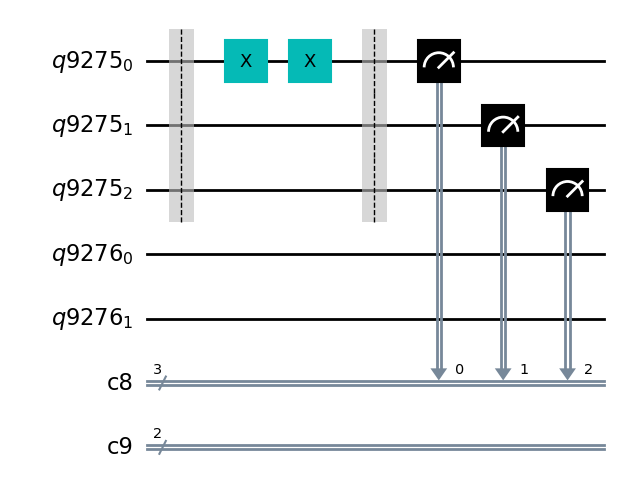

In [246]:
def apply_final_readout_invert(qc, qc_init, qreg_data, creg_data):
    """Apply inverse mapping so that we always try and measure |1> in the computational basis.
    
    TODO: The above is just a stand in for proper measurement basis measurement
    """
    qc = qc.compose(qc_init.inverse())
    qc.x(qreg_data[0])
    qc.barrier(qreg_data)
    qc.measure(qreg_data, creg_data)
    return qc

qc_final_measure_invert = apply_final_readout_invert(build_qc(), qc_init, qreg_data, creg_data)
qc_final_measure_invert.draw(output="mpl")

For comparison with a "raw" physical qubit we include the routine below which builds a circuit that idles instead of encoding and correcting our qubits. You should include this in your sweep.

In [247]:
from collections import defaultdict

from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import ASAPSchedule, PadDelay
from qiskit_ibm_provider.transpiler.passes.scheduling import DynamicCircuitScheduleAnalysis, PadDelay

def get_circuit_duration_(qc: QuantumCircuit) -> int:
    """Get duration of circuit in hardware cycles."""
    durations = InstructionDurations.from_backend(backend)
    pm = PassManager([DynamicCircuitScheduleAnalysis(durations)])
    pm.run(qc)
    node_start_times = pm.property_set["node_start_time"]
    
    block_durations = defaultdict(int)
    for inst, (block, t0) in node_start_times.items():
        block_durations[block] = max(block_durations[block], t0+inst.op.duration)
        
    duration = sum(block_durations.values())
    
    # If we are running on real hardware the delays have not been appended to the
    # circuit directly and are instead built into the conditional operations.
    # We account for them manually here
    if not sim:
        duration += block_branch_cycles * (len(block_durations) - 1)
    return duration

def build_idle_error_correction_sequence(
    qc_base: QuantumCircuit,
    qc_init: Optional[QuantumCircuit], 
    qc_encode: QuantumCircuit, 
    qc_channels: List[QuantumCircuit],
    qc_syndrome: QuantumCircuit,
    qc_correct: QuantumCircuit,
    qc_decode: Optional[QuantumCircuit] = None,
    qc_final: Optional[QuantumCircuit] = None,
    initial_layout=initial_layout,
    name: str = None,
) -> QuantumCircuit:
    """Build a quantum circuit that idles for the period of the input error correction sequence."""
    qc = qc_base
    
    if qc_init:
        qc = qc.compose(
            qc_init
        )
    if name is not None:
        qc.name = name

    qc_idle_region = qc_base.copy()
    
    qc_idle_region.compose(
            qc_encode
        )
  
    if not qc_channels:
        qc_channels = [QuantumCircuit(*qc.qregs)]
        
    for qc_channel in qc_channels:
        qc_idle_region = qc_idle_region.compose(
                qc_channel
            ).compose(
                qc_syndrome
            ).compose(
                qc_correct
            )
    
    if qc_decode:
        qc_idle_region = qc_idle_region.compose(qc_decode)
    
    qc_idle_transpiled = apply_transpile(qc_idle_region, backend, initial_layout=initial_layout, scheduling_method=None)
    idle_duration = get_circuit_duration_(qc_idle_transpiled)
    
    qc_idle = qc_base.copy()
    qc_idle.barrier()
    for qubit in qc_idle.qubits:
        qc_idle.delay(idle_duration, qubit, unit="dt")
    qc_idle.barrier()
    qc = qc.compose(qc_idle)
    
    if qc_final:
        qc = qc.compose(qc_final_measure)
    
    return qc

### 3a. Complete the routine below to create an "idle" error channel

In [248]:
def build_idle_error_channel(time_in_seconds, qreg):
    idle_cycles = convert_cycles(time_in_seconds, backend)
    qc_idle = build_qc()
    qc_idle.delay(idle_cycles, qreg, "dt")
    qc_idle.barrier()
    return qc_idle

### 3b. Complete the routine below to perform a sweep of our bit-flip, no-correction, and idle circuits for a number of iterations.

*hint*: Make sure to use the routines `build_error_correction_sequence` and `build_idle_error_correction_sequence`.

In [249]:
num_rounds = 5

# Idle for a specified period in seconds
# This is how we build an idle error channel
idle_period = 5e-6

# Use the circuit we created above
qc_idle = build_idle_error_channel(idle_period, qreg_data)


qcs_corr_bit = []
qcs_no_corr_bit = []
qcs_idle_equiv_bit = []
for round_ in range(num_rounds):
    qc_error_channels = [qc_idle] * (round_ + 1)
    
    #qcs_corr_bit.append(QuantumCircuit())

    qcs_corr_bit.append(
        build_error_correction_sequence(
            build_qc(),
            qc_init,
            qc_encode_bit,
            qc_error_channels,
            qc_syndrome_bit,
            qc_correction_bit,
            qc_decode_bit,
            qc_final_measure_invert,
            f"With Correction {round_}"
        )
    )
    #qcs_no_corr_bit.append(QuantumCircuit())
    qcs_no_corr_bit.append(
        build_error_correction_sequence(
            build_qc(),
            qc_init,
            qc_encode_bit,
            qc_error_channels,
            qc_syndrome_bit,
            qc_no_correction_bit,
            qc_decode_bit,
            qc_final_measure_invert,
            name=f"Without Correction {round_}"
        )
    )
    
    #qcs_idle_equiv_bit.append(QuantumCircuit())
    qcs_idle_equiv_bit.append(
        build_idle_error_correction_sequence(
            build_qc(),
            qc_init,
            qc_encode_bit,
            qc_error_channels,
            qc_syndrome_bit,
            qc_correction_bit,
            qc_decode_bit,
            qc_final_measure_invert,
            initial_layout=initial_layout,
            name=f"Idle {round_}"
        )
    )


Below we execute and plot the circuit we constructed.

In [250]:
transpiled_qcs_corr_bit = apply_transpile(qcs_corr_bit, backend, initial_layout=initial_layout)
job_qcs_corr_bit = execute(transpiled_qcs_corr_bit)

transpiled_qcs_no_corr_bit = apply_transpile(qcs_no_corr_bit, backend, initial_layout=initial_layout)
job_qcs_no_corr_bit = execute(transpiled_qcs_no_corr_bit)

transpiled_qcs_idle_equiv_bit = apply_transpile(qcs_idle_equiv_bit, backend, initial_layout=initial_layout)
job_qcs_idle_equiv_bit = execute(transpiled_qcs_idle_equiv_bit)

result_qcs_corr_bit = job_qcs_corr_bit.result()
result_qcs_no_corr_bit = job_qcs_no_corr_bit.result()
result_qcs_idle_equiv_bit = job_qcs_idle_equiv_bit.result()

In [251]:
from qiskit.quantum_info.analysis import hellinger_fidelity

qc_init_outcome = qc_init.copy()
qc_init_outcome = qc_init_outcome.compose(qc_final_measure)
result_ideal = ideal_sim.run(apply_transpile(qc_init_outcome, backend, initial_layout)).result()

def calculate_hellinger_fidelity(result_ideal, result_experiment, data_qubit=0):
    result_ideal = marginal_counts(result_ideal, indices=[data_qubit])
    result_experiment = marginal_counts(result_experiment, indices=[data_qubit])
    
    counts_ideal = result_ideal.get_counts(0)

    hellinger_fidelities = []
    for circuit_idx in range(len(result_experiment.results)):
        hellinger_fidelities.append(hellinger_fidelity(counts_ideal, result_experiment.get_counts(circuit_idx)))

    return hellinger_fidelities

### 3c. Use the routuine `calculate_hellinger_fidelity` above to extract the Hellinger fidelity for our sweeps

In [252]:
fidelities_corr_bit = calculate_hellinger_fidelity(result_ideal, result_qcs_corr_bit)
fidelities_no_corr_bit = calculate_hellinger_fidelity(result_ideal, result_qcs_no_corr_bit)
fidelities_idle_equiv_bit = calculate_hellinger_fidelity(result_ideal, result_qcs_idle_equiv_bit)

Below we plot the performance of our error correcting code as a function of the number of iterations.

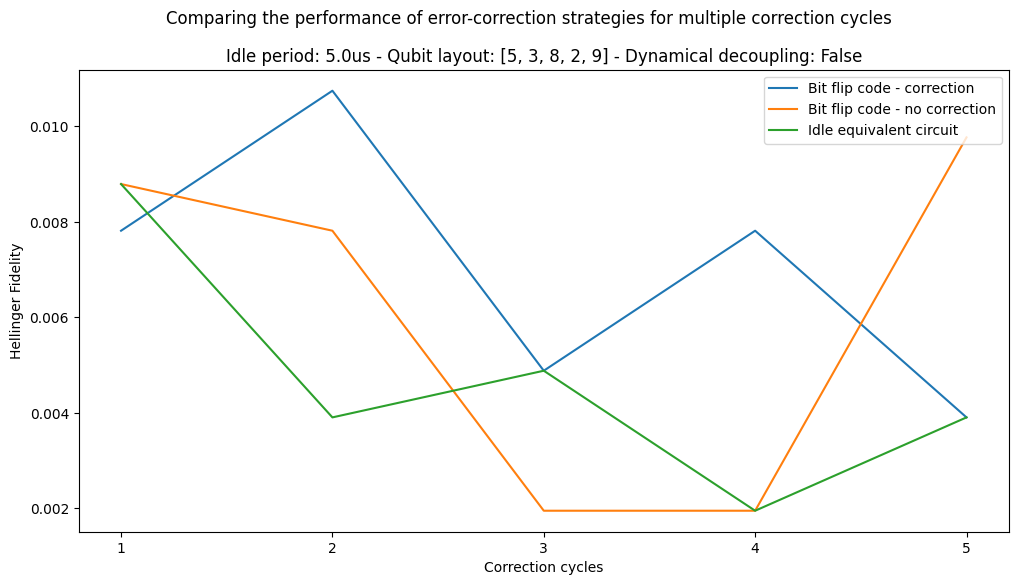

In [253]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)

iters = range(1, num_rounds+1)
plt.plot(iters, fidelities_corr_bit, label="Bit flip code - correction")
plt.plot(iters, fidelities_no_corr_bit, label="Bit flip code - no correction")
plt.plot(iters, fidelities_idle_equiv_bit, label="Idle equivalent circuit")
plt.ylabel("Hellinger Fidelity")
plt.xlabel("Correction cycles")
plt.xticks(iters)
plt.suptitle("Comparing the performance of error-correction strategies for multiple correction cycles")
plt.title(f"Idle period: {idle_period*1e6}us - Qubit layout: {initial_layout} - Dynamical decoupling: {dynamical_decoupling}")
plt.legend(loc="upper right")

## Exercise #3 - Evaluate the performance of protecting different input states

Thus far we have only been preparing the state $|001>$ and encoding it as $|111>$.
What we *actually* care about is the average quality of protecting *any* input state.
Rerun your analysis code above but instead of initializing with the `|1>` state,
select a different state.

**Note**: Make sure to save your results before overwriting them. Either save your plots or create a copy of this notebook.

- How do other states perform? 
- Does the quality improve or get worse?
- Why might we expect the `|1>` to perform the best?
- What sorts of noise might be affecting the qubits?

## Exercise #4 - Rerun with dynamical decoupling enabled

Dynamical decoupling is a technique which can decouple a qubit from neighboring
quantum systems during its evolution [0](https://arxiv.org/abs/quant-ph/9803057). 
Qiskit supports adding dynamical decoupling by identifying idle sequences in which
identity sequences (such as $\tau/4-X-\tau/2-X-\tau/4$) may be automatically inserted
by a [specialized pass](https://github.com/Qiskit/qiskit-ibm-provider/blob/06490ab5ccfabc1ceae79bc3e8ba3f8bb82296fa/qiskit_ibm_provider/transpiler/passes/scheduling/dynamical_decoupling.py#L32).

This notebook already has dynamical decoupling support built-in to `apply_transpile`.
To enable it set `dynamical_decoupling=True` and rerun the notebook.


**Note**: Make sure to save your results before overwriting them. Either save your plots or create a copy of this notebook.

- How does this perform for your state $|1>$? What about other states?
- What constraints does dynamical decoupling have that might make it more difficult to implement in dynamic circuits? 

## Exercise #5 (Stretch) - Implement the Phase-flip code

The phase-flip code is the analog of the bit-flip code which can detect and correct any *single* phase-flip (Z) error.

*Hint #1* Its implementation is very similar to that of the bit-flip code as a phase error in the computational (Z) basis is an X error in the X-basis.

*Hint #2* See this [notebook](https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/awards/teach_me_quantum_2018/intro2qc/10.Quantum%20error%20correction.ipynb)

### 5a.  Complete the routine below similar to `encode_bit_flip` above


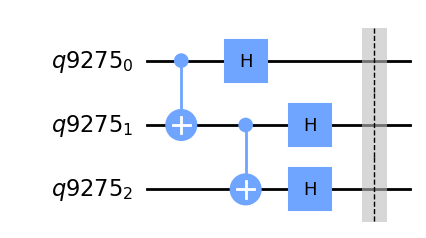

In [254]:
def encode_phase_flip(qc, state, ancillas):
    control = state
    for ancilla in ancillas:
        qc.cx(control, ancilla)
        control = ancilla
    qc.h(state)
    qc.h(ancillas)
    qc.barrier(state, *ancillas)
    return qc

qc_encode_phase = build_qc()

encode_phase_flip(qc_encode_phase, state_data, ancillas_data)

qc_encode_phase.draw(output="mpl", idle_wires=False)

### 5b. Complete the routine below similar to `encode_syndrome_bit` above


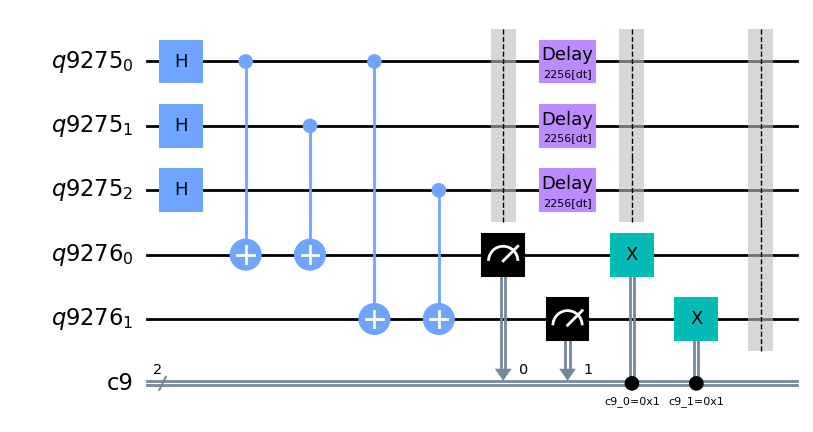

In [255]:
def measure_syndrome_phase(qc, qreg_data, qreg_measure, creg_measure):
    def branch_delay():
        if sim:
            qc.barrier(qreg_data)
            qc.delay(block_branch_cycles, qreg_data)
            qc.barrier(qreg_data)

    qc.h(qreg_data)
    qc.cx(qreg_data[0], qreg_measure[0])
    qc.cx(qreg_data[1], qreg_measure[0])
    qc.cx(qreg_data[0], qreg_measure[1])
    qc.cx(qreg_data[2], qreg_measure[1])
    qc.measure(qreg_measure, creg_measure)
    branch_delay()
    qc.x(qreg_measure[0]).c_if(creg_measure[0], 1)
    qc.x(qreg_measure[1]).c_if(creg_measure[1], 1)
    qc.barrier(*qreg_data, *qreg_measure)
    
    #qc.h(qreg_data)
    return qc

qc_syndrome_phase = measure_syndrome_phase(build_qc(), qreg_data, qreg_measure, creg_syndrome)
qc_syndrome_phase.draw(output="mpl", idle_wires=False)    

### 5c. Complete the routine below similar to `decode_bit_flip` above


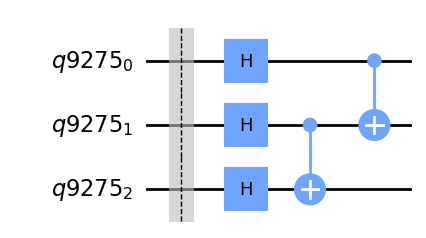

In [256]:
def decode_phase_flip(qc, state, ancillas):
    inv = qc_encode_phase.inverse()
    return qc.compose(inv)

qc_decode_phase = build_qc()

qc_decode_phase = decode_phase_flip(qc_decode_phase, state_data, ancillas_data)

qc_decode_phase.draw(output="mpl", idle_wires=False)

### 5d. Complete the routine below similar to `apply_correction_phase` above


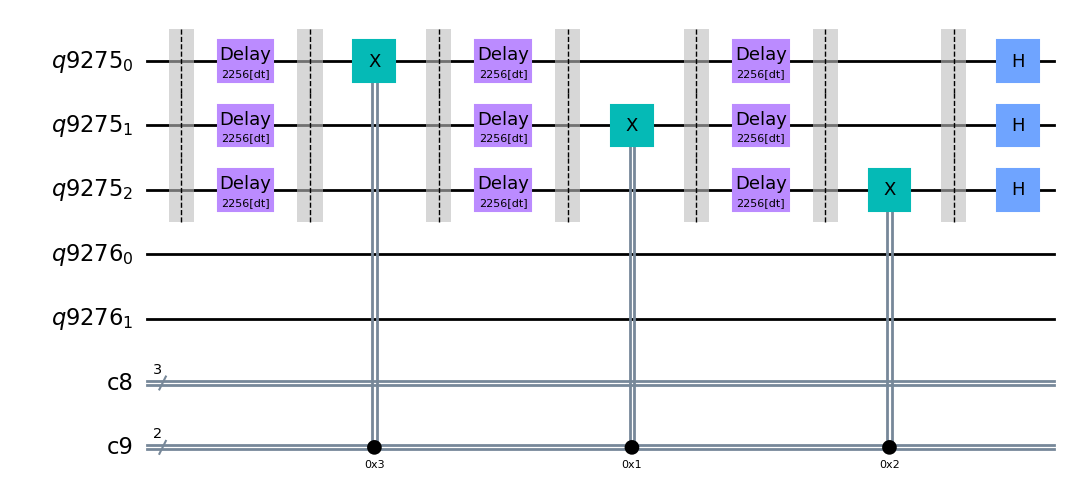

In [257]:
def apply_correction_phase(qc, qreg_data, creg_syndrome):
    # If simulating we need to insert a delay to mirror the hardware
    def branch_delay():
        if sim:
            qc.barrier(qreg_data)
            qc.delay(block_branch_cycles, qreg_data)
            qc.barrier(qreg_data)
    
    branch_delay()
    qc.x(qreg_data[0]).c_if(creg_syndrome, 3)
    branch_delay()
    qc.x(qreg_data[1]).c_if(creg_syndrome, 1)
    branch_delay()
    qc.x(qreg_data[2]).c_if(creg_syndrome, 2)
    qc.barrier(qreg_data)
    qc.h(qreg_data)
    return qc
    
qc_correction_phase = apply_correction_phase(build_qc(), qreg_data, creg_syndrome)
qc_correction_phase.draw(output="mpl")

### 5e. Build experiment circuits with our random error channel widgets from above and evaluate the performance
(This is similar to what we completed at the end of the tutorial)

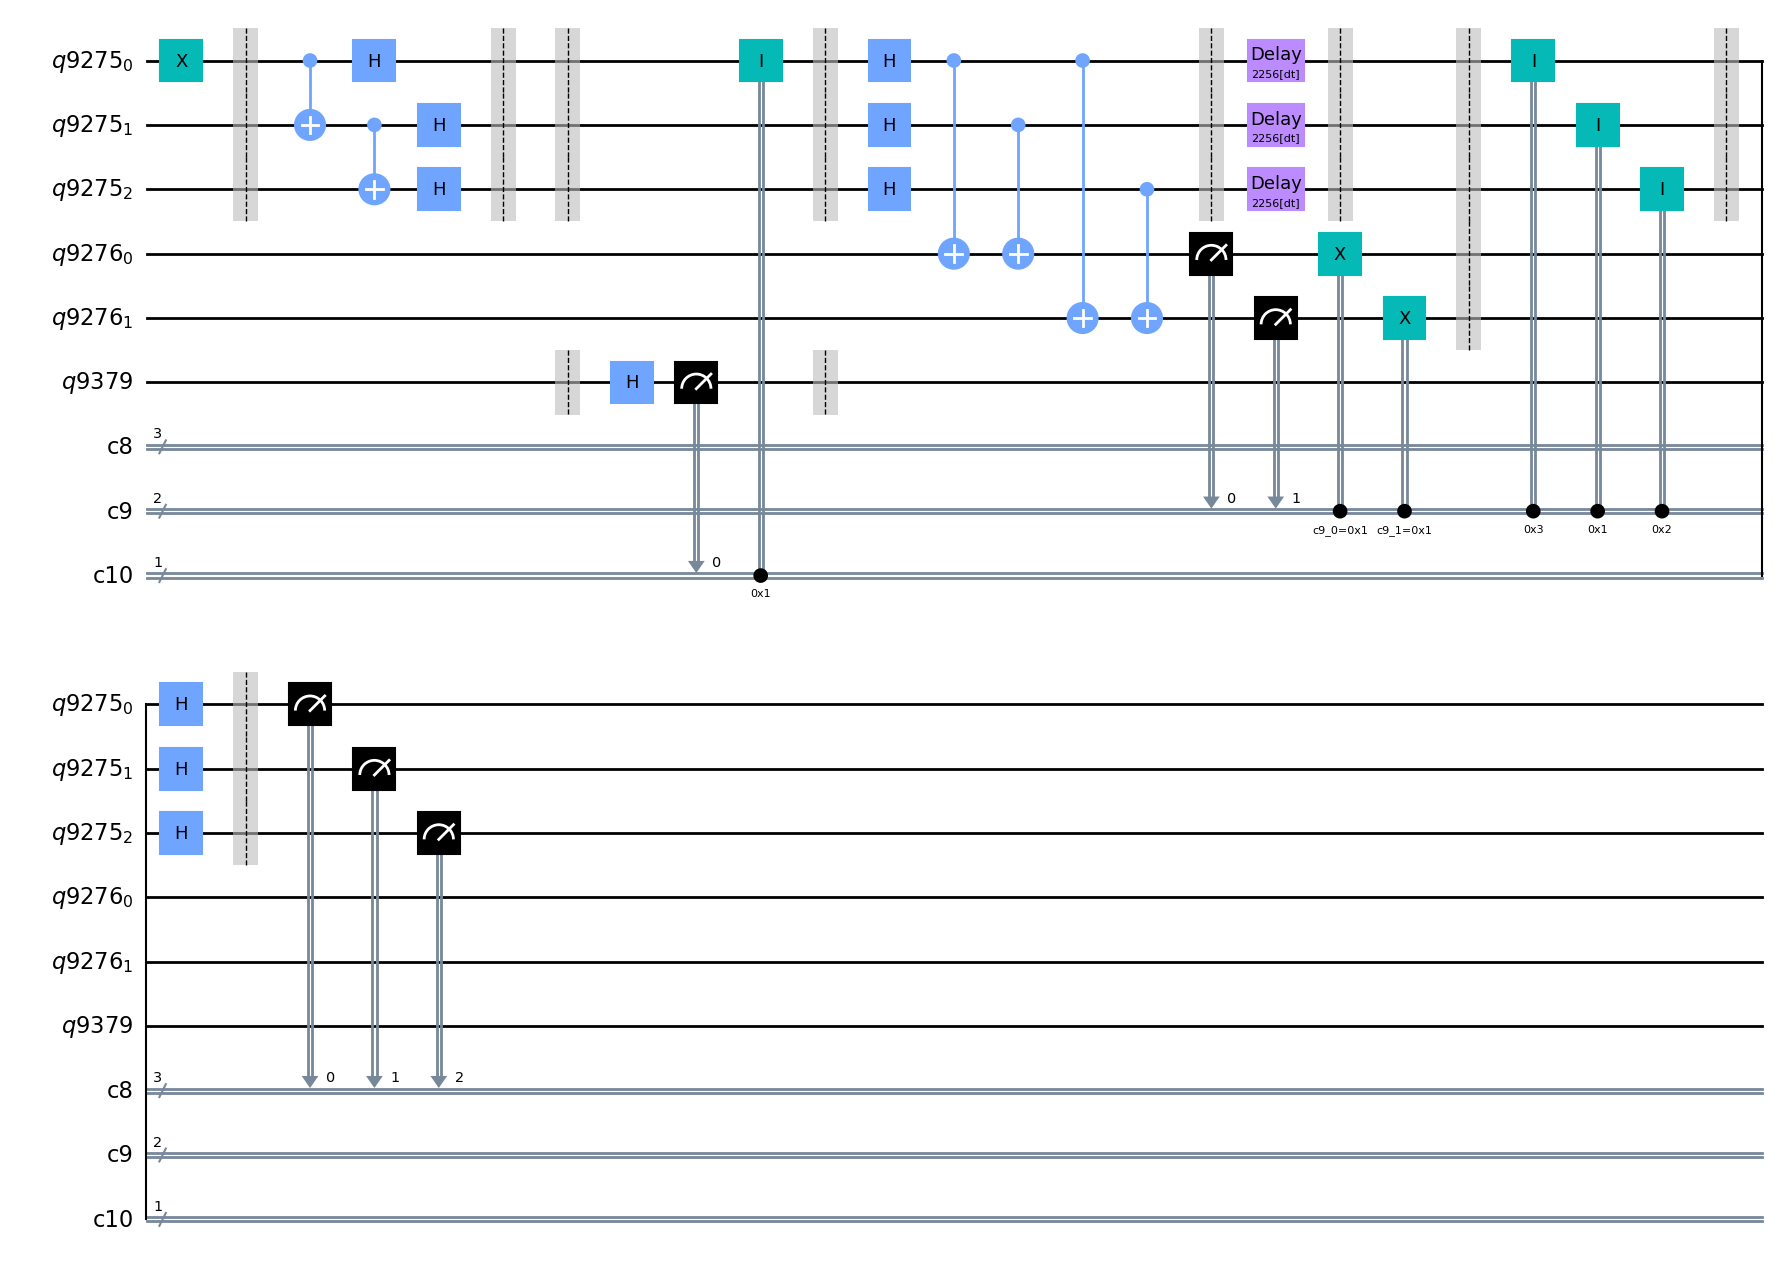

In [258]:
qc_id_error_no_correct = QuantumCircuit() # build_error_correction_sequence(...)
qc_bit_flip_error_no_correct = QuantumCircuit() # build_error_correction_sequence(...)
qc_phase_flip_error_no_correct = QuantumCircuit() # build_error_correction_sequence(...)

qc_id_error_no_correct_phase = build_error_correction_sequence(
    build_error_channel_base(),
    qc_init,
    qc_encode_phase,
    [qc_id_error_channel],
    qc_syndrome_phase,
    qc_no_correction_phase,
    None,
    qc_final_measure,
    "Identity error channel"
)

qc_bit_flip_error_no_correct_phase = build_error_correction_sequence(
    build_error_channel_base(),
    qc_init,
    qc_encode_phase,
    [qc_bit_flip_error_channel],
    qc_syndrome_phase,
    qc_no_correction_phase,
    None,
    qc_final_measure,
    "Bit flip error channel"
)

qc_phase_flip_error_no_correct_phase = build_error_correction_sequence(
    build_error_channel_base(),
    qc_init,
    qc_encode_phase,
    [qc_phase_flip_error_channel],
    qc_syndrome_phase,
    qc_no_correction_phase,
    None,
    qc_final_measure,
    "Phase flip error channel"
)

circuits_error_channels_no_correct_phase = [qc_id_error_no_correct_phase, qc_bit_flip_error_no_correct_phase, qc_phase_flip_error_no_correct_phase]

qc_id_error_no_correct_phase.draw(output="mpl")

In [259]:
# We need to add an extra ancilla qubit to our layout
# It doesn't matter which qubit for the must part as we are using as a
# source of random information
error_channel_layout = error_channel_layout = initial_layout + list(set(range(circuits_error_channels_no_correct_phase[0].num_qubits)) - set(initial_layout))[:1]

transpiled_circuits_error_channels_no_correct = apply_transpile(circuits_error_channels_no_correct_phase, backend, initial_layout=error_channel_layout)
result_error_channels_no_correct_phase = execute(circuits_error_channels_no_correct_phase).result()

In [260]:
qc_init_outcome = qc_init.copy()
qc_init_outcome.measure(qreg_data[0], 0)

qreg_indices = list(range(len(qreg_data)))
data_indices = qreg_indices[:1]
syndrome_indices = list(range(qreg_indices[-1]+1, len(qreg_data) + len(qreg_measure) ))

result_decoded_data_qubit_marginal_no_correct_phase = marginal_counts(result_error_channels_no_correct_phase, data_indices)
result_data_marginal_no_correct_phase = marginal_counts(result_error_channels_no_correct_phase, qreg_indices)
result_syndrome_marginal_no_correct_phase = marginal_counts(result_error_channels_no_correct_phase, syndrome_indices)

for i, qc in enumerate(transpiled_circuits_error_channels_no_correct):
    print(f"For {qc.name} with bit flip code")
    print(f'    Completed bit code experiment decoded data qubit measurement counts {result_decoded_data_qubit_marginal_no_correct_phase.get_counts(i)}')
    print(f'    Completed bit code experiment data qubits measurement counts {result_data_marginal_no_correct_phase.get_counts(i)}')
    print(f'    Completed bit code experiment syndrome measurement counts {result_data_marginal_no_correct_phase.get_counts(i)}')
    decode_error_channel_result(qc_init_outcome, result_data_marginal_no_correct_phase.get_counts(i), result_syndrome_marginal_no_correct_phase.get_counts(i), indent=4);
    print("")

For Identity error channel with bit flip code
    Completed bit code experiment decoded data qubit measurement counts {'0': 1022, '1': 2}
    Completed bit code experiment data qubits measurement counts {'000': 999, '001': 2, '100': 12, '010': 11}
    Completed bit code experiment syndrome measurement counts {'000': 999, '001': 2, '100': 12, '010': 11}
    Bit flip errors were corrected on 16/1024 trials
    A final parity error was detected on 25/1024 trials
    For the successful trials the Hellinger fidelity is 0.0

For Bit flip error channel with bit flip code
    Completed bit code experiment decoded data qubit measurement counts {'0': 1019, '1': 5}
    Completed bit code experiment data qubits measurement counts {'000': 997, '100': 17, '001': 5, '010': 5}
    Completed bit code experiment syndrome measurement counts {'000': 997, '100': 17, '001': 5, '010': 5}
    Bit flip errors were corrected on 19/1024 trials
    A final parity error was detected on 27/1024 trials
    For the s

### 5f. Gather data for multiple cycles of the phase-flip code's syndrome and compare it against data collected in Exercise #2

*hint*: The steps are nearly equivalent to those in exercise #2. Copy the circuit construction, execution, analysis and plotting routines and add the phase flip code.

Complete the constructions of circuits for a number of stabilizer iterations for the phase flip code

In [261]:
num_rounds = 5

# Idle for a specified period in seconds
# This is how we build an idle error channel
idle_period = 5e-6

# Use the circuit we created above
qc_idle = build_idle_error_channel(idle_period, qreg_data)


qcs_corr_phase = []
qcs_no_corr_phase = []
for round_ in range(num_rounds):
    qc_error_channels = [qc_idle] * (round_ + 1)
    
    #qcs_corr_phase.append(QuantumCircuit())
    qcs_corr_phase.append(
        build_error_correction_sequence(
            build_qc(),
            qc_init,
            qc_encode_phase,
            qc_error_channels,
            qc_syndrome_phase,
            qc_correction_phase,
            qc_decode_phase,
            qc_final_measure_invert,
            f"With Correction {round_}"
        )
    )
    #qcs_no_corr_bit.append(QuantumCircuit())
    qcs_no_corr_phase.append(
        build_error_correction_sequence(
            build_qc(),
            qc_init,
            qc_encode_phase,
            qc_error_channels,
            qc_syndrome_phase,
            qc_no_correction_phase,
            qc_decode_phase,
            qc_final_measure_invert,
            name=f"Without Correction {round_}"
        )
    )

Execute our sweep for the phase flip code 

In [262]:
transpiled_qcs_corr_phase = apply_transpile(qcs_corr_phase, backend, initial_layout=initial_layout)
job_qcs_corr_phase = execute(transpiled_qcs_corr_phase)

transpiled_qcs_no_corr_phase = apply_transpile(qcs_no_corr_phase, backend, initial_layout=initial_layout)
job_qcs_no_corr_phase = execute(transpiled_qcs_no_corr_phase)

result_qcs_corr_phase = job_qcs_corr_phase.result()
result_qcs_no_corr_phase = job_qcs_no_corr_phase.result()

Calculate the fidelities for our phase flip sweep

In [263]:
fidelities_corr_phase = calculate_hellinger_fidelity(result_ideal, result_qcs_corr_phase)
fidelities_no_corr_phase = calculate_hellinger_fidelity(result_ideal, result_qcs_no_corr_phase)

Plot the result of our sweep including the phase flip data

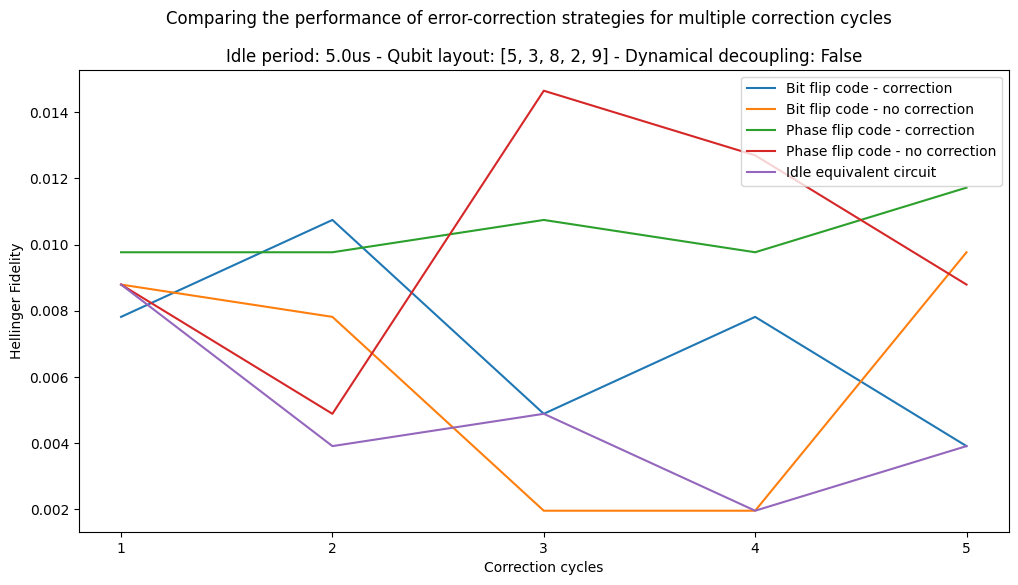

In [264]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)

iters = range(1, num_rounds+1)
plt.plot(iters, fidelities_corr_bit, label="Bit flip code - correction")
plt.plot(iters, fidelities_no_corr_bit, label="Bit flip code - no correction")
plt.plot(iters, fidelities_corr_phase, label="Phase flip code - correction")
plt.plot(iters, fidelities_no_corr_phase, label="Phase flip code - no correction")
plt.plot(iters, fidelities_idle_equiv_bit, label="Idle equivalent circuit")
plt.ylabel("Hellinger Fidelity")
plt.xlabel("Correction cycles")
plt.xticks(iters)
plt.suptitle("Comparing the performance of error-correction strategies for multiple correction cycles")
plt.title(f"Idle period: {idle_period*1e6}us - Qubit layout: {initial_layout} - Dynamical decoupling: {dynamical_decoupling}")
plt.legend(loc="upper right")

## Exercise #5 (Stretch) - Implement Quantum Process Tomography

As alluded to in exercise #2, we actually care not just about the result for a single input state and measurement basis, but the collective performance over *all* input states and measurement basis. This property is known as a [quantum process or channel](https://en.wikipedia.org/wiki/Quantum_channel) and is defined by a completely positive trace preserving (CPTP) map.

We may use the technique known as [Quantum Process Tomography](https://qiskit.org/documentation/stable/0.25/tutorials/noise/8_tomography.html) to estimate the quantum channel that corresponds to our bit-flip code cycle (which ideally should perfectly protect our qubit and be equivalent to the identity channel).

Below use Qiskit Ignis and its [process tomography](https://qiskit.org/documentation/stable/0.25/tutorials/noise/8_tomography.html) routines to calculate the average gate fidelity of our bit-flip and bit-flip (identity correction) sequences.

*hint*: You will have to build your bit-flip circuit *without* an initial state preparation and measurement, as the tomography routines will manange these for you.

In [265]:
# Create circuits without state preparation and measurement
# as these will be applied by QPT.


# Idle for a us
idle_period = 5e-6
idle_cycles = convert_cycles(idle_period, backend)

qc_idle = build_qc()
qc_idle.delay(idle_cycles, qc_idle.qregs[0], "dt")
qc_idle.barrier()

qc_error_channels = [qc_idle]

qc_corr_bit_no_spam = build_error_correction_sequence(
        build_qc(),
        None,
        qc_encode_bit,
        qc_error_channels,
        qc_syndrome_bit,
        qc_correction_bit,
        qc_decode_bit,
        None,
        "With Correction"
    )
 
qc_no_corr_bit_no_spam = build_error_correction_sequence(
        build_qc(),
        None,
        qc_encode_bit,
        qc_error_channels,
        qc_syndrome_bit,
        qc_no_correction_bit,
        qc_decode_bit,
        None,
        name="Without Correction"
    )



In [266]:
from qiskit.circuit import Qubit
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter

def build_process_tomo_circuits(qc: QuantumCircuit, encoded_qubit: Qubit, post_delay: int = 10e-6):
    """Build process tomography circuits using Qiskit Ignis
    
    Args:
        qc: Quantum circuit to perform qpt on.
        encoded_qubits: Qubit to perform QPT on.
        post_delay: An additional delay to insert after the final measurements to allow for hardware
            buffering issues.
    """
    qpt = process_tomography_circuits(qc, encoded_qubit, prepared_qubits=encoded_qubit)
    for qc in qpt:
        qc.delay(convert_cycles(post_delay, backend), unit="dt")
    return qpt

def build_process_tomo_sweep(
    qec_circuits: List[QuantumCircuit], 
    encoded_qubit: Qubit, 
    layout: List[int],
) -> List[QuantumCircuit]:
    """Build a process tomography sweep for QEC iterations.
    
    Output will be a flat list of circuits where the first 12 circuits correspond to the first
    iterations QPT sequence, the next 12 the second iteration, so on and so forth.
    """
    process_tomo_circuits = []
    for circuit in qec_circuits:
        process_tomo_circuits.extend(build_process_tomo_circuits(circuit, encoded_qubit))
    return apply_transpile(process_tomo_circuits, backend, initial_layout=layout)

In [267]:
qpt_corr_bit = build_process_tomo_sweep([qc_corr_bit_no_spam], qreg_data[0], initial_layout)
qpt_no_corr_bit = build_process_tomo_sweep([qc_no_corr_bit_no_spam], qreg_data[0], initial_layout)

In [268]:
result_qpt_corr_bit = execute(qpt_corr_bit).result()
result_qpt_no_corr_bit = execute(qpt_no_corr_bit).result()

In [269]:
import copy
from qiskit.result import Result
# Break out circuits by QPT and trait fitter
def process_qpt(result, circuits):
    return ProcessTomographyFitter(result, circuits)
    
def process_qpt_sweep(sweep_result: Result, sweep_circuits: List[QuantumCircuit], num_rounds: int) -> List[ProcessTomographyFitter]:
    """Process and fit the tomography sweep built earlier."""
    circuits_per_round = 12
    fitters = []
    
    marginal_sweep_result = marginal_counts(sweep_result, indices=[0])
    for round_ in range(num_rounds):
        round_circuits = sweep_circuits[round_*circuits_per_round:(round_+1)*circuits_per_round]
        result = copy.deepcopy(marginal_sweep_result)
        result.results = result.results[round_*circuits_per_round:(round_+1)*circuits_per_round]
        fitters.append(process_qpt(result, round_circuits))
    return fitters


fitter_qpt_corr_bit = process_qpt_sweep(result_qpt_corr_bit, qpt_corr_bit, 1)[0]
fitter_qpt_no_corr_bit = process_qpt_sweep(result_qpt_no_corr_bit, qpt_no_corr_bit, 1)[0]



In [270]:
def calculate_chi_matrix(fitter):
    choi_fit_lstsq = fitter.fit(method='lstsq')
    return qi.Chi(choi_fit_lstsq)

def calculate_fidelity(fitter):
    return qi.average_gate_fidelity(calculate_chi_matrix(fitter), target=qi.Pauli("I"))
    

fidelity_qpt_corr_bit = calculate_fidelity(fitter_qpt_corr_bit)
fidelity_qpt_no_corr_bit = calculate_fidelity(fitter_qpt_no_corr_bit)

print(f"The average gate fidelity for the bit flip code on qubits {initial_layout} is {fidelity_qpt_corr_bit}")
print(f"The average gate fidelity for the bit flip code (without correction) on qubits {initial_layout} is {fidelity_qpt_no_corr_bit}")

The average gate fidelity for the bit flip code on qubits [5, 3, 8, 2, 9] is 0.49807148472200263
The average gate fidelity for the bit flip code (without correction) on qubits [5, 3, 8, 2, 9] is 0.5005247563415732


Text(0.5, 1.0, 'No Correction - Average gate fidelity: F = 0.498')

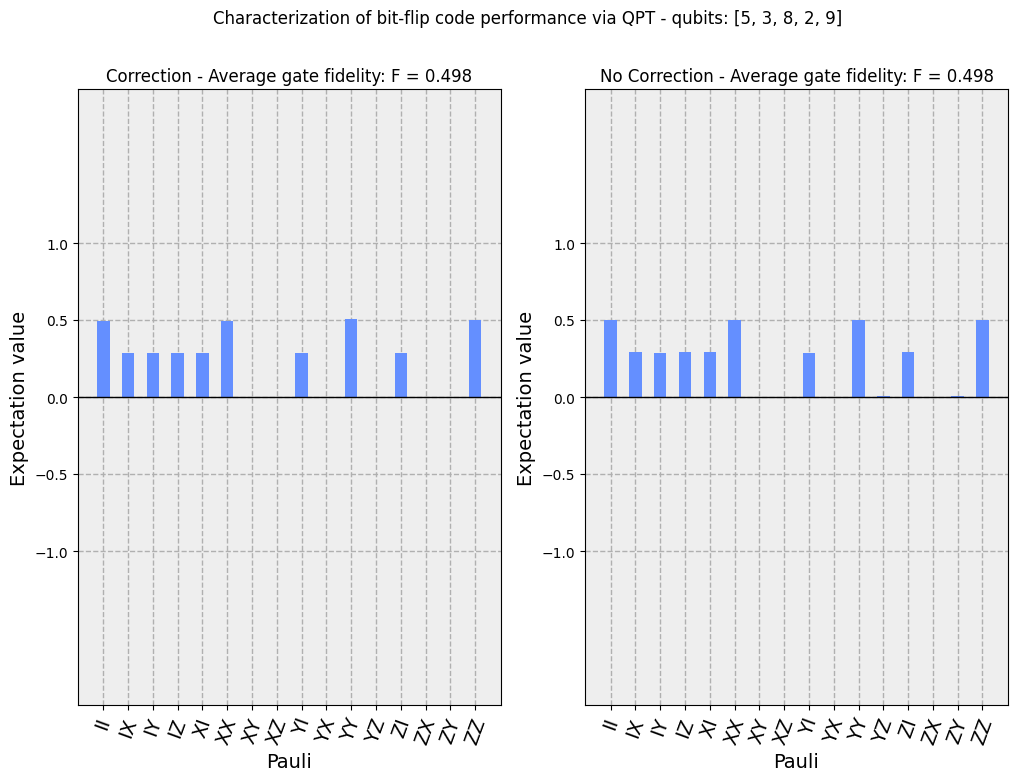

In [271]:
figsize = (12, 8)
fig, [ax_corr, ax_no_corr] = plt.subplots(1, 2, figsize=figsize)


bit_corr_data = (calculate_chi_matrix(fitter_qpt_corr_bit).data).flatten()
bit_no_corr_data = (calculate_chi_matrix(fitter_qpt_no_corr_bit).data).flatten()
labels = qiskit.quantum_info.pauli_basis(2).to_labels()


color = "#648fff"

corr_ind = np.arange(len(bit_corr_data))  # the x locations for the groups
no_corr_ind = np.arange(len(bit_no_corr_data))  # the x locations for the groups

width = 0.5  # the width of the bars

fig.suptitle(f"Characterization of bit-flip code performance via QPT - qubits: {initial_layout}")


ax_corr.grid(zorder=0, linewidth=1, linestyle="--")
ax_corr.bar(corr_ind, bit_corr_data, width, color=color, zorder=2)
ax_corr.axhline(linewidth=1, color="k")
# add some text for labels, title, and axes ticks
ax_corr.set_ylabel("Expectation value", fontsize=14)
ax_corr.set_xticks(corr_ind)
ax_corr.set_yticks([-1, -0.5, 0, 0.5, 1])
ax_corr.set_xticklabels(labels, fontsize=14, rotation=70)
ax_corr.set_xlabel("Pauli", fontsize=14)
ax_corr.set_ylim([-2, 2])
ax_corr.set_facecolor("#eeeeee")
ax_corr.set_xticklabels(labels, fontsize=14, rotation=70)
ax_corr.set_title(f"Correction - Average gate fidelity: F = {fidelity_qpt_corr_bit:.3f}")


ax_no_corr.grid(zorder=0, linewidth=1, linestyle="--")
ax_no_corr.bar(corr_ind, bit_no_corr_data, width, color=color, zorder=2)
ax_no_corr.axhline(linewidth=1, color="k")
# add some text for labels, title, and axes ticks
ax_no_corr.set_ylabel("Expectation value", fontsize=14)
ax_no_corr.set_xticks(no_corr_ind)
ax_no_corr.set_yticks([-1, -0.5, 0, 0.5, 1])
ax_no_corr.set_xticklabels(labels, fontsize=14, rotation=70)
ax_no_corr.set_xlabel("Pauli", fontsize=14)
ax_no_corr.set_ylim([-2, 2])
ax_no_corr.set_facecolor("#eeeeee")
ax_no_corr.set_xticklabels(labels, fontsize=14, rotation=70)
ax_no_corr.set_title(f"No Correction - Average gate fidelity: F = {fidelity_qpt_corr_bit:.3f}")

In [272]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright